In [25]:
import xarray as xr
import numpy as np
import zarr
import dask.array as da

from os import path

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
# from keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dropout, UpSampling2D, concatenate, Conv2DTranspose
import keras.layers as layers
from keras import Input

import calendar

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [26]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [27]:
# get data function
zarr_path = "../shared/data/IO.zarr"
zarr_ds = xr.open_zarr(store=zarr_path, consolidated=True)  # get data

# zarr_reg_slice = zarr_ds.sel(lat=slice(35, -5.25), lon=slice(45,79.75))  # choose long and lat
zarr_ds = zarr_ds.sel(lat=slice(32, -11.75), lon=slice(42,101.75))

all_nan_CHL = np.isnan(zarr_ds['CHL_cmes-level3']).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN

zarr_ds = zarr_ds.sel(time=(~all_nan_CHL))  # select samples with CHL not NaN

zarr_ds = zarr_ds.sortby('time')

# create mask function
CHL_mask = (~np.isnan(zarr_ds.sel(time='2018-10-01').CHL) & ~np.isnan(zarr_ds.sel(time='2018-10-01').sst)).compute()
CHL_mask[:30, 150:] = False

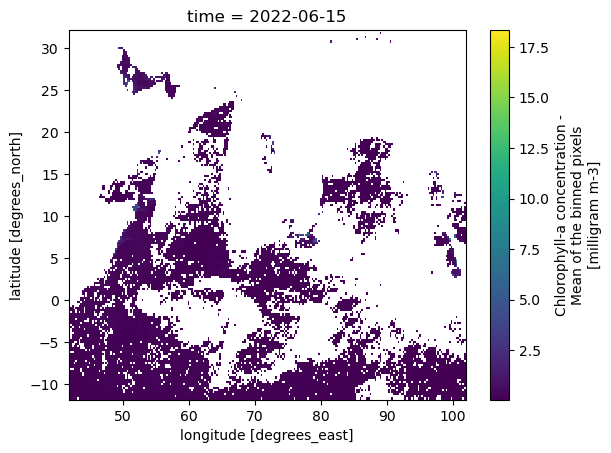

In [4]:
zarr_ds['CHL_cmes-level3'].sel(time='2022-06-15').plot()

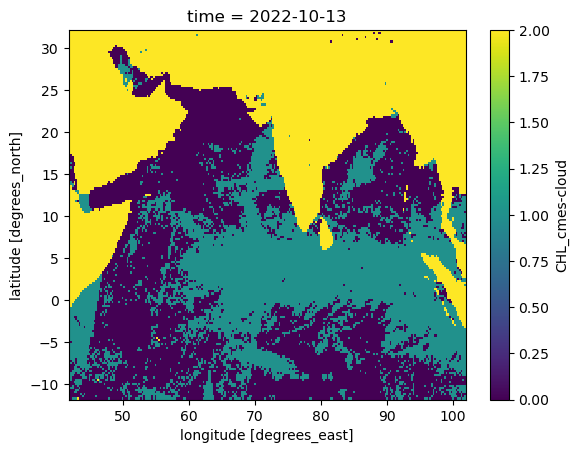

In [8]:
zarr_ds.sel(time='2022-10-13')['CHL_cmes-cloud'].plot()

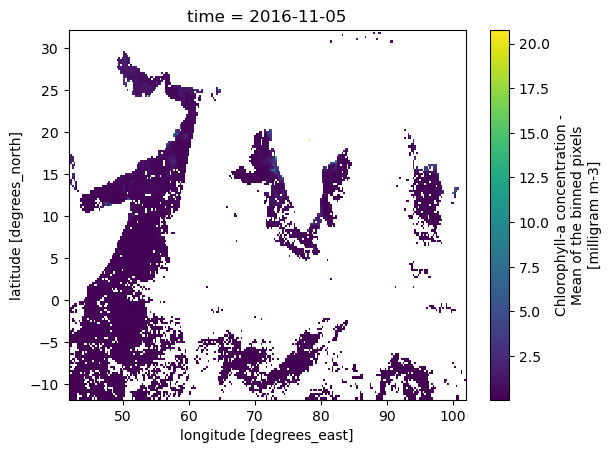

In [20]:
zarr_ds['CHL_cmes-level3'][7000].plot()

In [4]:
def data_preprocessing(zarr_ds, features, train_year, train_range, cloud_perc=None):
    '''
    zarr_ds: zarr dataset
    features: raw data variables for training
    # split_indices: [train_start, val_start, test_start, test_end]
    cloud_type: either 'random' or 'big'
    cloud_prob: if 'random'; probability of random cloud (not implemented)
    cloud_dim: tuple; if 'big'; size of big cloud
    '''
    numer_features = []  # numerical features
    cat_features = []  # categorical features
    zarr_label = f'{train_year}_{train_range}'  # later passed to create_zarr for identification
    zarr_label = f'{zarr_label}_full_2days' if cloud_perc is None else f'{zarr_label}_{cloud_perc}_2days'

    print('label created')

    if path.exists(f'data/{zarr_label}.zarr'):
        print('Zarr file exists')
        return zarr_label
    
    # add raw data features
    for feature in features:
        feat_arr = zarr_ds[feature].data
        numer_features.append(feat_arr)
    print('raw feature added')

    # get label
    CHL_data = zarr_ds['CHL_cmes-level3']
    CHL_data = np.log(CHL_data.copy())
    # CHL_data = da.rechunk(CHL_data, (100, *CHL_data.shape[1:]))

    print('CHL logged')
    
    # additional features
    # sin and cos of day for seasonal features
    time_data = da.array(zarr_ds.time)
    day_rad = (time_data - np.datetime64("1900-01-01")) / np.timedelta64(1, "D") / 365 * 2 * np.pi
    day_rad = day_rad.astype(np.float32)
    day_sin = np.sin(day_rad)
    day_cos = np.cos(day_rad)
    print('sin and cos time calculated')
    day_sin = np.tile(day_sin[:, np.newaxis, np.newaxis], (1,) + CHL_data[0].shape)
    day_sin = da.rechunk(day_sin, (100, *day_sin.shape[1:]))
    numer_features.append(day_sin)
    print('sin time added')
    day_cos = np.tile(day_cos[:, np.newaxis, np.newaxis], (1,) + CHL_data[0].shape)
    day_cos = da.rechunk(day_cos, (100, *day_cos.shape[1:]))
    numer_features.append(day_cos)
    print('cos time added')

    
    # artifically masked CHL
    day_shift_flag = np.vstack((zarr_ds['CHL_cmes-cloud'].data[10:], zarr_ds['CHL_cmes-cloud'].data[:10]))
    assert CHL_data.shape == day_shift_flag.shape
    # if cloud_type is None:
    #     pass
    # elif cloud_type == 'big':
    #     for i in range(len(fake_cloud_flag)):
    #         lat = np.random.randint(CHL_data[0].shape[0] - cloud_dim[0])
    #         lon = np.random.randint(CHL_data[0].shape[1] - cloud_dim[1])
    #         fake_cloud_flag[i, lat:lat+cloud_dim[0], lon:lon+cloud_dim[1]] = 1
    
    masked_CHL = da.where(day_shift_flag == 0, np.nan, CHL_data)
    numer_features.append(masked_CHL)

    print('masked CHL added')

    prev_day = np.vstack((np.zeros((1, ) + CHL_data[0].shape), CHL_data.data[:-1]))
    numer_features.append(prev_day)
    print('prev day CHL added')
    next_day = np.vstack((CHL_data.data[1:], np.zeros((1, ) + CHL_data[0].shape)))
    numer_features.append(next_day)
    print('next day CHL added')

    # land one-hot encoding
    land_flag = da.zeros(CHL_data.shape)
    land_flag = da.where(zarr_ds['CHL_cmes-cloud'][0] == 2, 1, land_flag)
    cat_features.append(land_flag)
    
    print('land flag added')

    # real cloud one-hot encoding
    real_cloud_flag = da.zeros(CHL_data.shape)
    real_cloud_flag = da.where(zarr_ds['CHL_cmes-cloud'] == 1, 1, real_cloud_flag)
    cat_features.append(real_cloud_flag)

    print('real cloud flag added')

    # valid CHL one-hot encoding
    valid_CHL_flag = da.zeros(CHL_data.shape)
    valid_CHL_flag = da.where(~da.isnan(masked_CHL), 1, valid_CHL_flag)
    cat_features.append(valid_CHL_flag)

    print('valid CHL flag added')

    
    # fake cloud one-hot encoding
    fake_cloud_flag = da.zeros(CHL_data.shape)
    fake_cloud_flag = da.where((land_flag + real_cloud_flag + valid_CHL_flag) == 0, 1, fake_cloud_flag)
    cat_features.append(fake_cloud_flag)

    print('fake cloud flag added')


    # cast features to dask array type
    # numer_features = da.array(numer_features)
    # cat_features = da.array(cat_features)

    # print('features casted to dask array')

    # find train data start and end indices
    train_start_ind = np.where(zarr_ds.time.values == np.datetime64(f'{train_year}-01-01'))[0][0]
    train_end_ind = np.where(zarr_ds.time.values == np.datetime64(f'{train_year + train_range}-01-01'))[0][0]
    

    # get mean and stdev for numerical features
    # X_train = numer_features[:, train_start_ind: train_end_ind]
    feat_mean = []
    feat_stdev = []

    for feature in numer_features:
        feature_train = feature[train_start_ind: train_end_ind]
        feat_mean.append(da.nanmean(feature_train).compute())
        feat_stdev.append(da.nanstd(feature_train).compute())
        print('calculating mean and stdev...')

    # calculate standardized features
    numer_features_stdized = []
    feature_shape = numer_features[0].shape
    for feature, mean, stdev in zip(numer_features, feat_mean, feat_stdev):
        numer_features_stdized.append((feature - da.full(feature_shape, mean)) / da.full(feature_shape, stdev))
        print('standardizing...')
    # numer_features_stdized = da.array(numer_features_stdized)

    # get mean and stdev for CHL
    CHL_mean = da.nanmean(CHL_data).compute()
    CHL_stdev = da.nanstd(CHL_data).compute()
    np.save(f'data/{zarr_label}.npy', {'CHL': np.array([CHL_mean, CHL_stdev]), 'masked_CHL': np.array([feat_mean[-3], feat_stdev[-3]])})

    # calculate standardized CHL
    CHL_data_stdized = (CHL_data - da.full(feature_shape, CHL_mean)) / da.full(feature_shape, CHL_stdev)

    print('all standardized')

    numer_var_names = features + ['sin_time', 'cos_time', 'masked_CHL', 'prev_day_CHL', 'next_day-CHL']
    cat_var_names = ['land_flag', 'real_cloud_flag', 'valid_CHL_flag', 'fake_cloud_flag']  # 改顺序！！！

    print('creating zarr')
    create_zarr(zarr_ds, numer_features_stdized, numer_var_names, cat_features, cat_var_names, CHL_data_stdized.data, zarr_label)

    del time_data, day_rad, day_sin, day_cos
    del feature, feat_arr
    del numer_features, numer_features_stdized, numer_var_names, cat_features, cat_var_names, CHL_data, CHL_data_stdized
    del feat_mean, feat_stdev
    
    return zarr_label


def create_zarr(zarr_ds, numer_features, numer_var_names, cat_features, cat_var_names, CHL_data, zarr_label):
    chunk_size = 100
    coord_names = ['time', 'lat', 'lon']
    coords = {coord_name: zarr_ds[coord_name] for coord_name in coord_names}

    # var_names = numer_var_names + cat_var_names + ['CHL']
    # features = numer_features + cat_features + CHL_data
    
    numer_features_dict = {var_name: (coord_names, feature) for var_name, feature in zip(numer_var_names, numer_features)}
    cat_features_dict = {var_name: (coord_names, feature) for var_name, feature in zip(cat_var_names, cat_features)}
    label_dict = {'CHL': (coord_names, CHL_data)}
    print('variables dicts loaded')
    
    ds_numer = xr.Dataset(numer_features_dict, coords=coords)
    ds_cat = xr.Dataset(cat_features_dict, coords=coords)
    ds_label = xr.Dataset(label_dict, coords=coords)
    print('xarray datasets created')

    # dict = {var_name: (coord_names, feature) for var_name, feature in zip(var_names, features)}
    
    # ds = xr.Dataset(dict, coords=coords)
    

    for var in list(ds_numer.keys()):
        ds_numer[var]=ds_numer[var].chunk({"time": chunk_size}) 
    for var in list(ds_cat.keys()):
        ds_cat[var]=ds_cat[var].chunk({"time": chunk_size})
    for var in list(ds_label.keys()):
        ds_label[var]=ds_label[var].chunk({"time": chunk_size}) 
    print('chunked')

    store = zarr.DirectoryStore(f'data/{zarr_label}.zarr')
    # ds.to_zarr(store, mode='w')
    ds_numer.to_zarr(store, mode='w')
    ds_cat.to_zarr(store, mode='a')
    ds_label.to_zarr(store, mode='a')
    # xr.open_zarr(store)

    del numer_features_dict, cat_features_dict, label_dict, ds_numer, ds_cat, ds_label, store
    
        

In [5]:
def UNet_noDropout(input_shape):
    inputs = Input(shape=input_shape)
    
    x = inputs

    filters = [64, 128, 256]
    ec_images = []

    for filter in filters:
        ec_images.append(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.MaxPooling2D()(x)
        x = layers.BatchNormalization()(x)

    for filter, ec_image in zip(filters[:-1][::-1], ec_images[::-1][:-1]):
        # x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        
        x = layers.concatenate([x, ec_image])
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
    x = layers.concatenate([x, ec_images[0]])
    outputs = layers.Conv2D(filters=1,
                      kernel_size=(3,3),
                      padding='same',
                      activation='linear'
                     )(x)

    unet_model = tf.keras.Model(inputs, outputs, name='U-net')

    return unet_model

In [6]:
def UNet_DoubleConv(input_shape):
    inputs = Input(shape=input_shape)
    
    x = inputs

    filters = [64, 128, 256]
    ec_images = []

    for filter in filters:
        ec_images.append(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.MaxPooling2D()(x)
        x = layers.BatchNormalization()(x)

    for filter, ec_image in zip(filters[:-1][::-1], ec_images[::-1][:-1]):
        # x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        
        x = layers.concatenate([x, ec_image])
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
    x = layers.concatenate([x, ec_images[0]])
    x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
    outputs = layers.Conv2D(filters=1,
                      kernel_size=(3,3),
                      padding='same',
                      activation='linear'
                     )(x)

    unet_model = tf.keras.Model(inputs, outputs, name='U-net')

    return unet_model

In [7]:
def UNet_UpDropout(input_shape):
    inputs = Input(shape=input_shape)
    
    x = inputs

    filters = [64, 128, 256]
    ec_images = []

    for filter in filters:
        ec_images.append(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.MaxPooling2D()(x)
        x = layers.BatchNormalization()(x)

    for filter, ec_image in zip(filters[:-1][::-1], ec_images[::-1][:-1]):
        # x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        
        x = layers.concatenate([x, ec_image])
        x = layers.Dropout(0.3)(x)
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
    x = layers.concatenate([x, ec_images[0]])
    # x = layers.Dropout(0.3)(x)
    outputs = layers.Conv2D(filters=1,
                      kernel_size=(3,3),
                      padding='same',
                      activation='linear'
                     )(x)

    unet_model = tf.keras.Model(inputs, outputs, name='U-net')

    return unet_model

In [8]:
def UNet_AllDropout(input_shape):
    inputs = Input(shape=input_shape)
    
    x = inputs

    filters = [64, 128, 256]
    ec_images = []

    for filter in filters:
        ec_images.append(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.MaxPooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
    
    for filter, ec_image in zip(filters[:-1][::-1], ec_images[::-1][:-1]):
        # x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        
        x = layers.concatenate([x, ec_image])
        x = layers.Dropout(0.3)(x)
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
    x = layers.concatenate([x, ec_images[0]])
    # x = layers.Dropout(0.3)(x)
    outputs = layers.Conv2D(filters=1,
                      kernel_size=(3,3),
                      padding='same',
                      activation='linear'
                     )(x)

    unet_model = tf.keras.Model(inputs, outputs, name='U-net')

    return unet_model

In [9]:
def UNet_Old(input_shape):    
    model = Sequential()
    
    # model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
    #                      input_shape=input_shape,
    #                      padding='same', return_sequences=False))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.3))
    filters = [64, 128, 256]
    # model.add(layers.ZeroPadding2D(input_shape=input_shape, padding=(10, 10)))
    for filter in filters:
        model.add(layers.Conv2D(
                                input_shape=input_shape, 
                                filters=filter, 
                                kernel_size=(3, 3),  
                                padding='same',
                                activation='relu'
                         ))
        model.add(layers.MaxPooling2D())
        model.add(layers.BatchNormalization())
        # model.add(layers.Dropout(0.2))

    for filter in filters[:-1][::-1]:
        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         ))
        model.add(layers.BatchNormalization())
        # model.add(layers.Dropout(0.2))

    # model.add(BatchNormalization())
    # model.add(Dropout(0.3))

    # model.add(Conv2D(filters=32, 
    #                  kernel_size=(5, 5), 
    #                  padding='same',
    #                  activation='relu'
    #                  ))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.3))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(filters=1, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     activation='linear'
                     ))
    # model.add(layers.Cropping2D((10, 10)))
    
    return model

In [10]:
features = ['u_wind', 'v_wind', 'sst', 'air_temp']
train_year = 2015
train_range = 3
val_range = 1
test_range = 1

zarr_label = data_preprocessing(zarr_ds, features, train_year, train_range)

label created
Zarr file exists


In [11]:
zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))

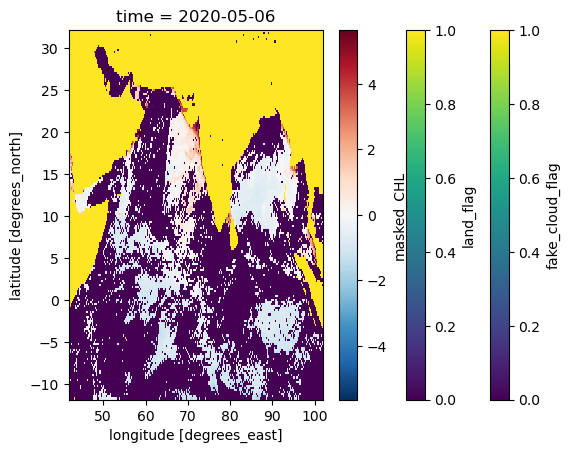

In [44]:
zarr_stdized['fake_cloud_flag'].sel(time='2020-05-06').plot()

zarr_stdized['land_flag'].sel(time='2020-05-06').plot()
zarr_stdized['masked_CHL'].sel(time='2020-05-06').plot()

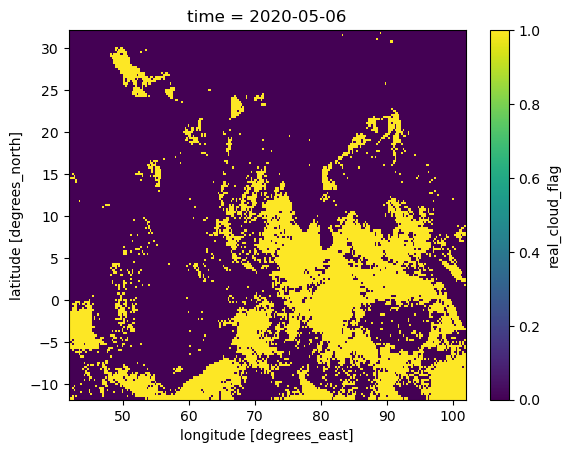

In [45]:
zarr_stdized['real_cloud_flag'].sel(time='2020-05-06').plot()

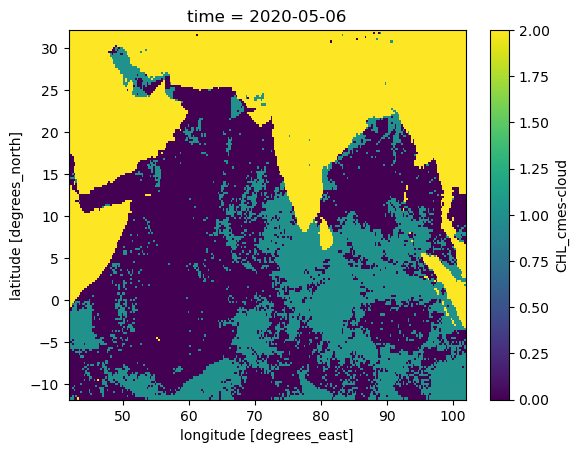

In [30]:
zarr_ds['CHL_cmes-cloud'].sel(time='2020-05-06').plot()


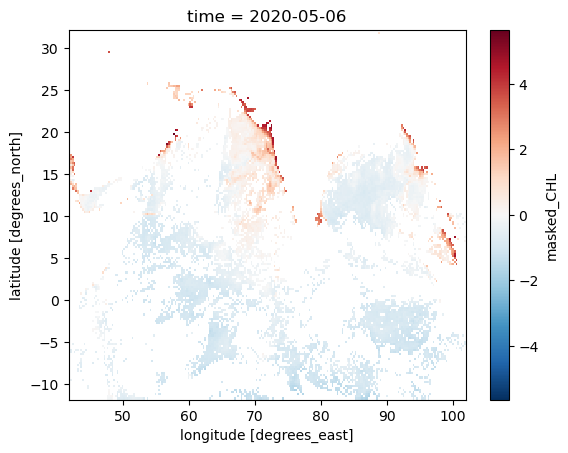

In [36]:
zarr_stdized['masked_CHL'].sel(time='2020-05-06').plot()

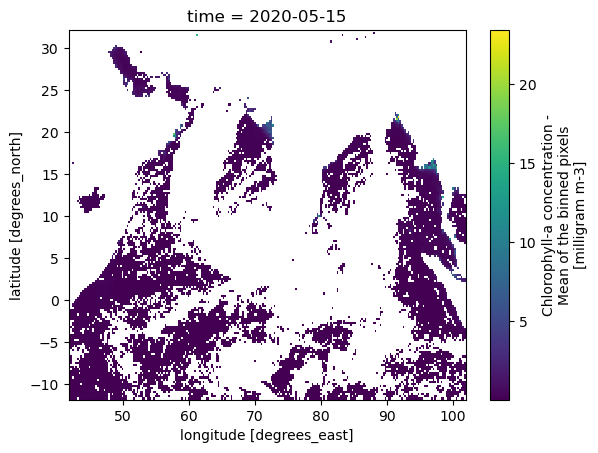

In [35]:
zarr_ds['CHL_cmes-level3'].sel(time='2020-05-15').plot()

In [12]:
X_vars = list(zarr_stdized.keys())
X_vars.remove('CHL')

zarr_train = zarr_stdized.sel(time=slice(f'{train_year}-01-01', f'{train_year+train_range}-01-01'))
X_train = []
for var in X_vars:
    var = zarr_train[var].to_numpy()
    X_train.append(np.where(np.isnan(var), 0.0, var))
y_train = zarr_train.CHL.to_numpy()
y_train = np.where(np.isnan(y_train), 0.0, y_train)
X_train = np.array(X_train)
X_train = np.moveaxis(X_train, 0, -1)
del zarr_train

zarr_val = zarr_stdized.sel(time=slice(f'{train_year+train_range}-01-01', f'{train_year+train_range+val_range}-01-01'))
X_val = []
for var in X_vars:
    var = zarr_val[var].to_numpy()
    X_val.append(np.where(np.isnan(var), 0.0, var))
y_val = zarr_val.CHL.to_numpy()
y_val = np.where(np.isnan(y_val), 0.0, y_val)
X_val = np.array(X_val)
X_val = np.moveaxis(X_val, 0, -1)
del zarr_val

zarr_test = zarr_stdized.sel(time=slice(f'{train_year+train_range+val_range}-01-01', f'{train_year+train_range+val_range+test_range}-01-01'))
X_test= []
for var in X_vars:
    var = zarr_test[var].to_numpy()
    X_test.append(np.where(np.isnan(var), 0.0, var))
y_test = zarr_test.CHL.to_numpy()
y_test = np.where(np.isnan(y_test), 0.0, y_test)
X_test = np.array(X_test)
X_test = np.moveaxis(X_test, 0, -1)
del zarr_test, var

In [13]:
def plot_losses(history):
    history_keys = list(history.history.keys())
    plot_num = len(history_keys) // 2
    plt.figure(figsize=(5 * plot_num, 4))
    for i in range(plot_num):
        plt.subplot(1, plot_num, i + 1)
        train_key = history_keys[i]
        val_key = history_keys[i + plot_num]
        plt.plot(history.history[train_key], label=f'Train {train_key}')
        plt.plot(history.history[val_key], label=f'Validation {val_key[4:]}')
        plt.title(train_key)
        plt.xlabel('Epoch')
        plt.ylabel(train_key)
        plt.legend(loc='upper right')
        plt.grid(True)
    # plt.suptitle(f'{test_year} Prediction Model Trained with {train_range} Years & Validated on {test_year - 1}')
    plt.show()

def test_loss(X_test, y_test, model, print_loss=True):
    # Prepare test dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(4)

    # Evaluate the model on the test dataset
    test_mae, test_mse = model.evaluate(test_dataset)
    if print_loss:
        print(f"Test MAE: {test_mae}")
        print(f"Test MSE: {test_mse}")
    return test_mae, test_mse

2024-07-25 22:17:17.826449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5
2024-07-25 22:17:18.947674: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
2024-07-25 22:17:20.612688: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
2024-07-25 22:17:22.441651: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1607823360 exceeds 10% of free system memory.
2024-07-25 22:17:22.861616: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1607823360 exceeds 10% of free system memory.


Epoch 1/50


2024-07-25 22:17:23.191335: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
I0000 00:00:1721945849.118620    2947 service.cc:145] XLA service 0x7f549410ab10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721945849.118810    2947 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-25 22:17:29.328479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 22:17:29.901944: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  3/275 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 0.5969 - mae: 0.5585  

I0000 00:00:1721945857.447421    2947 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 532 bytes spill stores, 460 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 184 bytes spill stores, 184 bytes spill loads

I0000 00:00:1721945857.456272    2947 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - loss: 0.1171 - mae: 0.1961 - val_loss: 0.0541 - val_mae: 0.1270
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0339 - mae: 0.0955 - val_loss: 0.0325 - val_mae: 0.0967
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0256 - mae: 0.0811 - val_loss: 0.0260 - val_mae: 0.0780
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0205 - mae: 0.0727 - val_loss: 0.0223 - val_mae: 0.0750
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0179 - mae: 0.0665 - val_loss: 0.0197 - val_mae: 0.0681
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0159 - mae: 0.0613 - val_loss: 0.0229 - val_mae: 0.0732
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0144 - mae: 0.0577 - val_loss: 0.0163 - val_mae: 0.0593
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0124 - mae: 0.0527 - val_loss: 0.0152 - val_mae: 0.0563
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/st

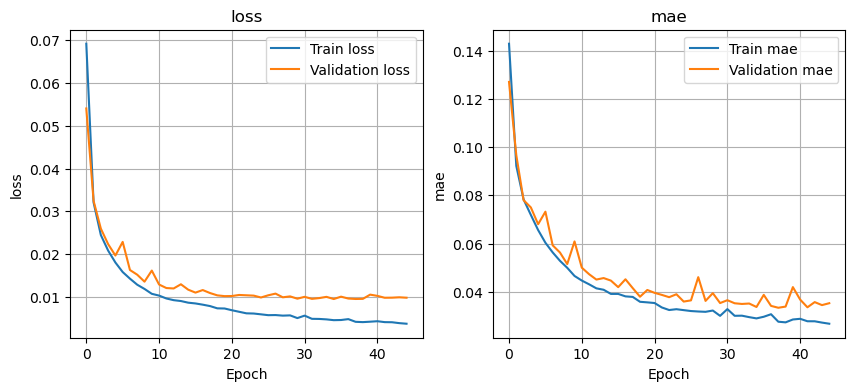

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0132 - mae: 0.0448
Test MAE: 0.013506653718650341
Test MSE: 0.04424223303794861
Epoch 1/50
  2/275 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 0.9541 - mae: 0.7481 

I0000 00:00:1721946417.916343    2946 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 992 bytes spill stores, 832 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 184 bytes spill stores, 184 bytes spill loads



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1408 - mae: 0.2188

I0000 00:00:1721946432.415512    2946 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads



275/275 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - loss: 0.1405 - mae: 0.2186 - val_loss: 0.0625 - val_mae: 0.1392
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0418 - mae: 0.1062 - val_loss: 0.0354 - val_mae: 0.0861
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0306 - mae: 0.0867 - val_loss: 0.0287 - val_mae: 0.0801
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0260 - mae: 0.0787 - val_loss: 0.0250 - val_mae: 0.0710
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0223 - mae: 0.0703 - val_loss: 0.0229 - val_mae: 0.0681
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0210 - mae: 0.0671 - val_loss: 0.0214 - val_mae: 0.0659
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0209 - mae: 0.0665 - val_loss: 0.0192 - val_mae: 0.0585
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0177 - mae: 0.0594 - val_loss: 0.0168 - val_mae: 0.0557
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/st

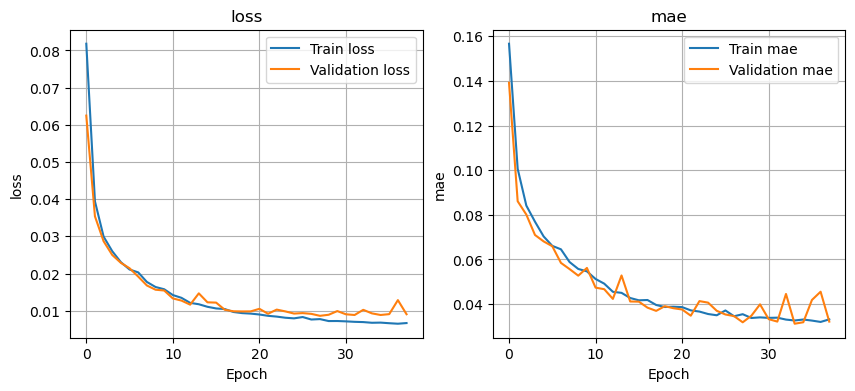

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0118 - mae: 0.0414
Test MAE: 0.01227579079568386
Test MSE: 0.0416368693113327
Epoch 1/50
  3/275 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.6322 - mae: 0.5917  

I0000 00:00:1721946901.715081    2949 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 1832 bytes spill stores, 1504 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_6', 72 bytes spill stores, 72 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_7', 184 bytes spill stores, 184 bytes spill loads



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1456 - mae: 0.2255

I0000 00:00:1721946920.014557    2946 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 20 bytes spill stores, 20 bytes spill loads



275/275 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - loss: 0.1454 - mae: 0.2253 - val_loss: 0.0653 - val_mae: 0.1186
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0474 - mae: 0.1105 - val_loss: 0.0386 - val_mae: 0.0903
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0338 - mae: 0.0902 - val_loss: 0.0286 - val_mae: 0.0772
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0280 - mae: 0.0805 - val_loss: 0.0249 - val_mae: 0.0692
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0245 - mae: 0.0739 - val_loss: 0.0234 - val_mae: 0.0696
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0231 - mae: 0.0714 - val_loss: 0.0211 - val_mae: 0.0650
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0207 - mae: 0.0656 - val_loss: 0.0190 - val_mae: 0.0611
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0195 - mae: 0.0627 - val_loss: 0.0181 - val_mae: 0.0595
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/st

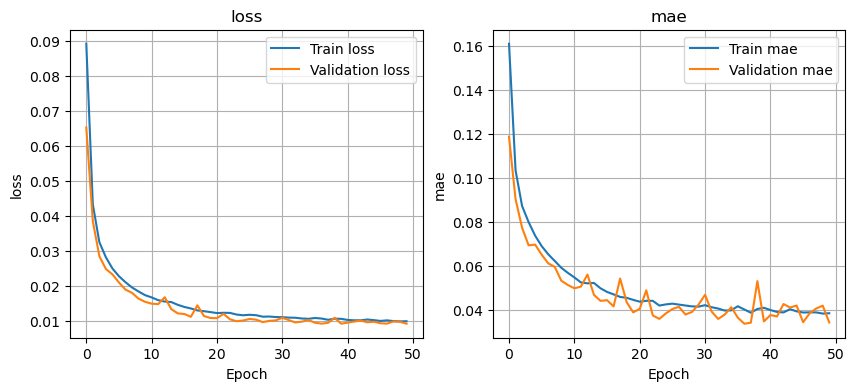

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0128 - mae: 0.0444
Test MAE: 0.01333712786436081
Test MSE: 0.04453438147902489
Epoch 1/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 1:33:29 20s/step - loss: 0.6606 - mae: 0.6277

I0000 00:00:1721947566.288151    2946 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 532 bytes spill stores, 460 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_8', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_11', 184 bytes spill stores, 184 bytes spill loads



275/275 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - loss: 0.0850 - mae: 0.1567 - val_loss: 0.0237 - val_mae: 0.0674
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - loss: 0.0129 - mae: 0.0553 - val_loss: 0.0146 - val_mae: 0.0565
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - loss: 0.0099 - mae: 0.0459 - val_loss: 0.0113 - val_mae: 0.0475
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - loss: 0.0085 - mae: 0.0414 - val_loss: 0.0093 - val_mae: 0.0400
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - loss: 0.0079 - mae: 0.0371 - val_loss: 0.0103 - val_mae: 0.0446
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - loss: 0.0068 - mae: 0.0331 - val_loss: 0.0091 - val_mae: 0.0363
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - loss: 0.0061 - mae: 0.0301 - val_loss: 0.0093 - val_mae: 0.0410
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - loss: 0.0062 - mae: 0.0308 - val_loss: 0.0080 - val_mae: 0.0360
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/s

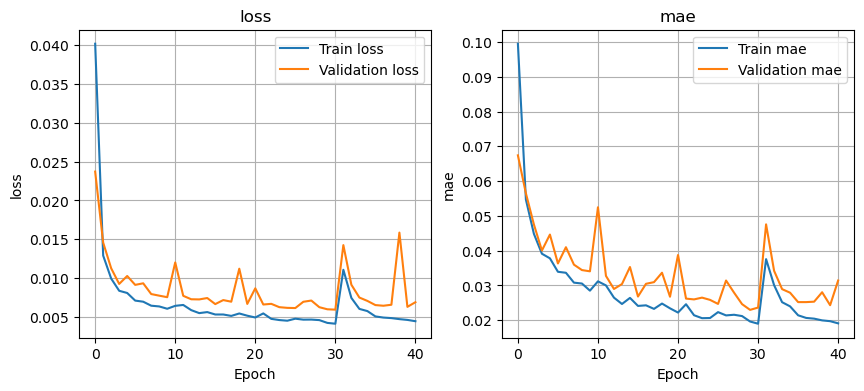

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0079 - mae: 0.0315
Test MAE: 0.008336339145898819
Test MSE: 0.03168705850839615


In [15]:
models = [UNet_noDropout, UNet_UpDropout, UNet_AllDropout, UNet_DoubleConv]
model_names = ['UNet_noDropout_mse', 'UNet_UpDropout_mse', 'UNet_AllDropout_mse', 'UNet_DoubleConv_mse']

for model, model_name in zip(models, model_names):
    model = model(input_shape=X_train.shape[1:])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    # process train
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=512).batch(4)
    # process val
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(4)
    # fit
    history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stop])
    
    # plot history
    plot_losses(history)
    # calculate test loss
    test_loss(X_test, y_test, model)
    del train_dataset, val_dataset

    model.save(f'models/{zarr_label}/{model_name}.keras')

/srv/conda/envs/notebook/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-18 22:05:49.879262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14782 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5
2024-07-18 22:05:50.882560: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4077680640 exceeds 10% of free system memory.
2024-07-18 22:05:51.885209: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4077680640 exceeds 10% of free system memory.


Epoch 1/50


2024-07-18 22:05:53.600977: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4077680640 exceeds 10% of free system memory.
I0000 00:00:1721340356.932547     557 service.cc:145] XLA service 0x7f048c0013a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721340356.932592     557 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-18 22:05:57.012377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 22:05:57.371050: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  5/275 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 1.5948 - mse: 4.6984

I0000 00:00:1721340363.226986     557 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 0.4115 - mse: 0.6153 - val_loss: 0.2365 - val_mse: 0.2706
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.2170 - mse: 0.1737 - val_loss: 0.1901 - val_mse: 0.1784
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.2003 - mse: 0.1499 - val_loss: 0.2062 - val_mse: 0.1660
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.1861 - mse: 0.1320 - val_loss: 0.1873 - val_mse: 0.1388
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.1870 - mse: 0.1267 - val_loss: 0.1888 - val_mse: 0.1432
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.1802 - mse: 0.1211 - val_loss: 0.1697 - val_mse: 0.1385
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.1737 - mse: 0.1109 - val_loss: 0.1599 - val_mse: 0.1040
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.1673 - mse: 0.1031 - val_loss: 0.1512 - val_mse: 0.1029
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - los

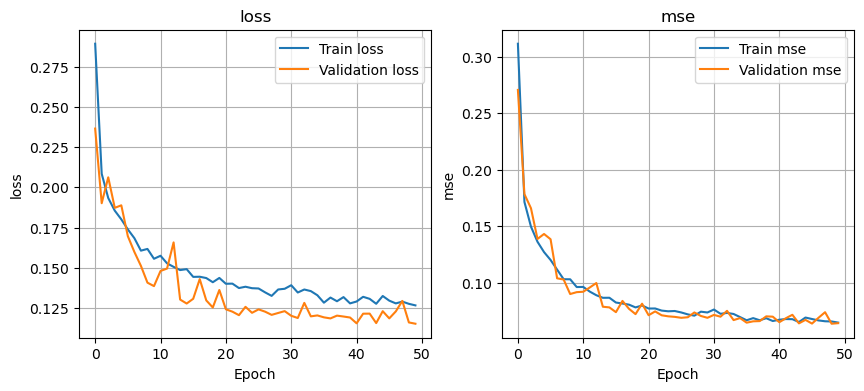

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1089 - mse: 0.0554
Test MAE: 0.11367259919643402
Test MSE: 0.062231481075286865


In [13]:
models = [UNet_Old]
model_names = ['UNet_Old']

for model, model_name in zip(models, model_names):
    model = model(input_shape=X_train.shape[1:])
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    # process train
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=512).batch(4)
    # process val
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(4)
    # fit
    history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stop])
    
    # plot history
    plot_losses(history)
    # calculate test loss
    test_loss(X_test, y_test, model)

    model.save(f'models/{zarr_label}/{model_name}.keras')

2024-07-25 18:39:32.063499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5
2024-07-25 18:39:33.223271: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
2024-07-25 18:39:34.484794: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
2024-07-25 18:39:35.932374: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1607823360 exceeds 10% of free system memory.
2024-07-25 18:39:36.351804: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1607823360 exceeds 10% of free system memory.


Epoch 1/50


2024-07-25 18:39:36.677952: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
I0000 00:00:1721932782.153921     554 service.cc:145] XLA service 0x7f6f600021f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721932782.153984     554 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-25 18:39:42.268351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 18:39:42.776671: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  1/275 ━━━━━━━━━━━━━━━━━━━━ 1:29:33 20s/step - loss: 0.4598 - mse: 0.4221

I0000 00:00:1721932796.156727     554 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 532 bytes spill stores, 460 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_8', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_11', 184 bytes spill stores, 184 bytes spill loads

I0000 00:00:1721932796.170527     554 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.1301 - mse: 0.0834 - val_loss: 0.0584 - val_mse: 0.0335
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 0.0422 - mse: 0.0192 - val_loss: 0.0419 - val_mse: 0.0189
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 0.0319 - mse: 0.0136 - val_loss: 0.0385 - val_mse: 0.0191
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - loss: 0.0281 - mse: 0.0113 - val_loss: 0.0331 - val_mse: 0.0136
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - loss: 0.0263 - mse: 0.0100 - val_loss: 0.0328 - val_mse: 0.0145
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - loss: 0.0257 - mse: 0.0111 - val_loss: 0.0289 - val_mse: 0.0108
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - loss: 0.0265 - mse: 0.0115 - val_loss: 0.0269 - val_mse: 0.0102
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - loss: 0.0204 - mse: 0.0074 - val_loss: 0.0318 - val_mse: 0.0117
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/s

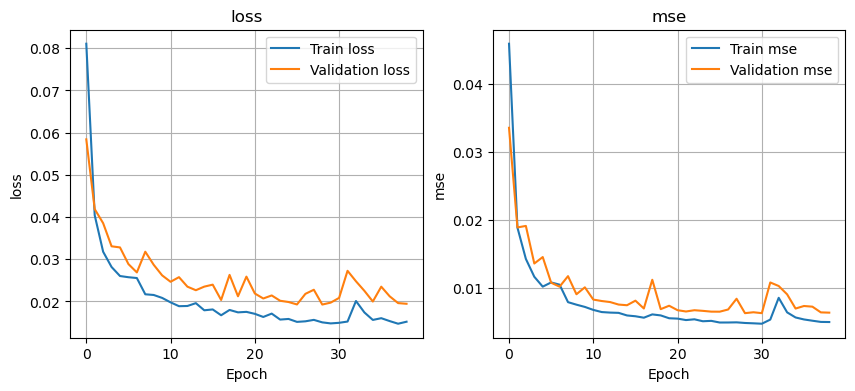

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0273 - mse: 0.0083
Test MAE: 0.027578746899962425
Test MSE: 0.008899574168026447


In [14]:
model = UNet_DoubleConv(input_shape=X_train.shape[1:])
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
# process train
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=512).batch(4)
# process val
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(4)
# fit
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stop])

# plot history
plot_losses(history)
# calculate test loss
test_loss(X_test, y_test, model)

model.save(f'models/{zarr_label}/UNet_DoubleConv.keras')

In [35]:
a = np.array([[1,2], [2,3]])
a ** 2

array([[1, 4],
       [4, 9]])

In [14]:
def unstdize(stdized_image, mean, stdev):
    return stdized_image * stdev + mean

def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

def compute_mse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean((y_true[mask] - y_pred[mask]) ** 2)

def mean_error(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.abs(np.mean(y_true[mask]) - np.mean(y_pred[mask]))

In [15]:
def plot_comparison(zarr_label, model, model_name, date_to_predict):
    zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))
    mean_std = np.load(f'data/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    # true_CHL = unstdize(true_CHL, mean, std)
    fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    masked_CHL = np.where(fake_cloud_flag == 1, np.nan, true_CHL)
    # masked_CHL = unstdize(masked_CHL, mean, std)
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    diff = true_CHL - predicted_CHL

    vmax = np.nanmax((true_CHL, masked_CHL, predicted_CHL, diff))
    vmin = np.nanmin((true_CHL, masked_CHL, predicted_CHL, diff))

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    im = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax)
    axes[0, 0].set_title('True log CHL', size=14)
    im = axes[0, 1].imshow(masked_CHL, vmin=vmin, vmax=vmax)
    # im = axes[0, 1].imshow(true_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    axes[0, 1].set_title('Masked log CHL', size=14)
    # im = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    # predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)  #
    im = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax)
    axes[1, 0].set_title('Predicted log CHL', size=14)

    vmin2 = np.nanmin(diff)
    vmax2 = np.nanmax(diff)
    vmax2 = np.nanmax((np.abs(vmin2), np.abs(vmax2)))
    vmin2 = -vmax2
    # im2 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, cmap=plt.cm.RdBu, alpha=0.3)  #
    # diff = np.where(fake_cloud_flag == 0, np.nan, diff)  #
    im2 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, cmap=plt.cm.RdBu)
    axes[1, 1].set_title('Difference (True - Pred)', size=14)

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)

    cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    fig.colorbar(im2, cax=cbar2_ax)

    predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    mae = compute_mae(true_CHL, predicted_CHL)
    mae = round(mae, 4)
    mse = compute_mse(true_CHL, predicted_CHL)
    mse = round(mse, 4)

    plt.suptitle(f'{date_to_predict} prediction with {model_name}\nMAE = {str(mae)}, MSE = {str(mse)}', size=16, y=0.95)
    plt.show()

In [16]:
def plot_daily_losses(zarr_label, model, model_name, year, plot=True):
    zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))
    mean_std = np.load(f'data/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')
    title = f'{year} daily loss with {model_name}'
    zarr_time_range = zarr_stdized.sel(time=time_range)

    mae = []
    mse = []

    # for date in np.arange(f'{year}-01', f'{year + 1}-01', dtype='datetime64[D]'):
    #     if date not in time_range:
    #         losses.append(np.nan)
    #     else:
            # zarr_date = zarr_stdized.sel(time=date)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    fake_cloud_flag = zarr_time_range.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
        mse.append(compute_mse(true, pred))
        
    if plot:
        plt.plot(mae, label='mae')
        plt.plot(mse, label='mse')
        plt.legend()
    
        tick_pos = []
        tick_label = []
        total_day = 1
        tick_pos.append(total_day + 15)
        tick_label.append('1')
        for month in range(1, 12):
            total_day += calendar.monthrange(year, month)[1]
            plt.axvline(total_day, color='grey', alpha=0.3)
            tick_pos.append(total_day + 15)
            tick_label.append(str(month+1))
        plt.title(title)
        plt.xlabel('Month')
        plt.ylabel('Loss')
        plt.xlim(1, len(losses))
        plt.xticks(tick_pos, tick_label)
        plt.show()

    # return (mae, mse)
    return mae

In [19]:
zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))


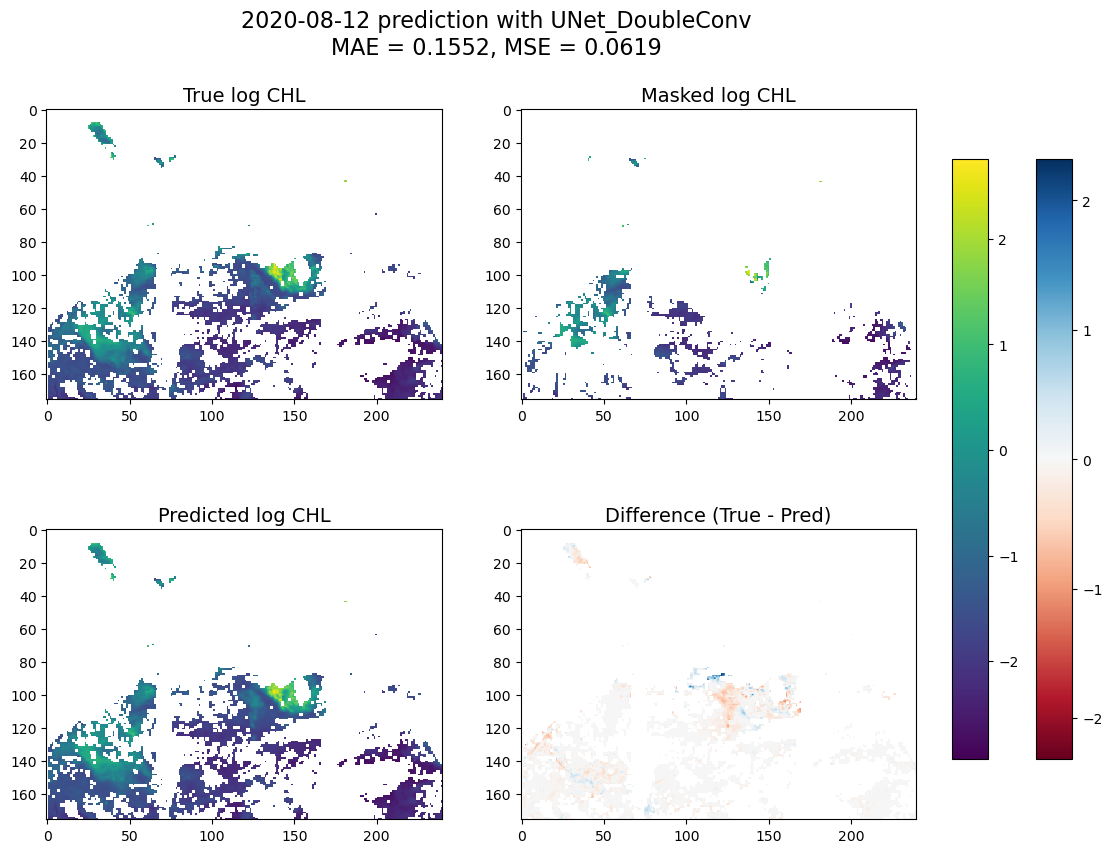

In [39]:
date = '2020-08-12'

model_name = 'UNet_DoubleConv'
model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
plot_comparison(zarr_label, model, 'UNet_DoubleConv', date)

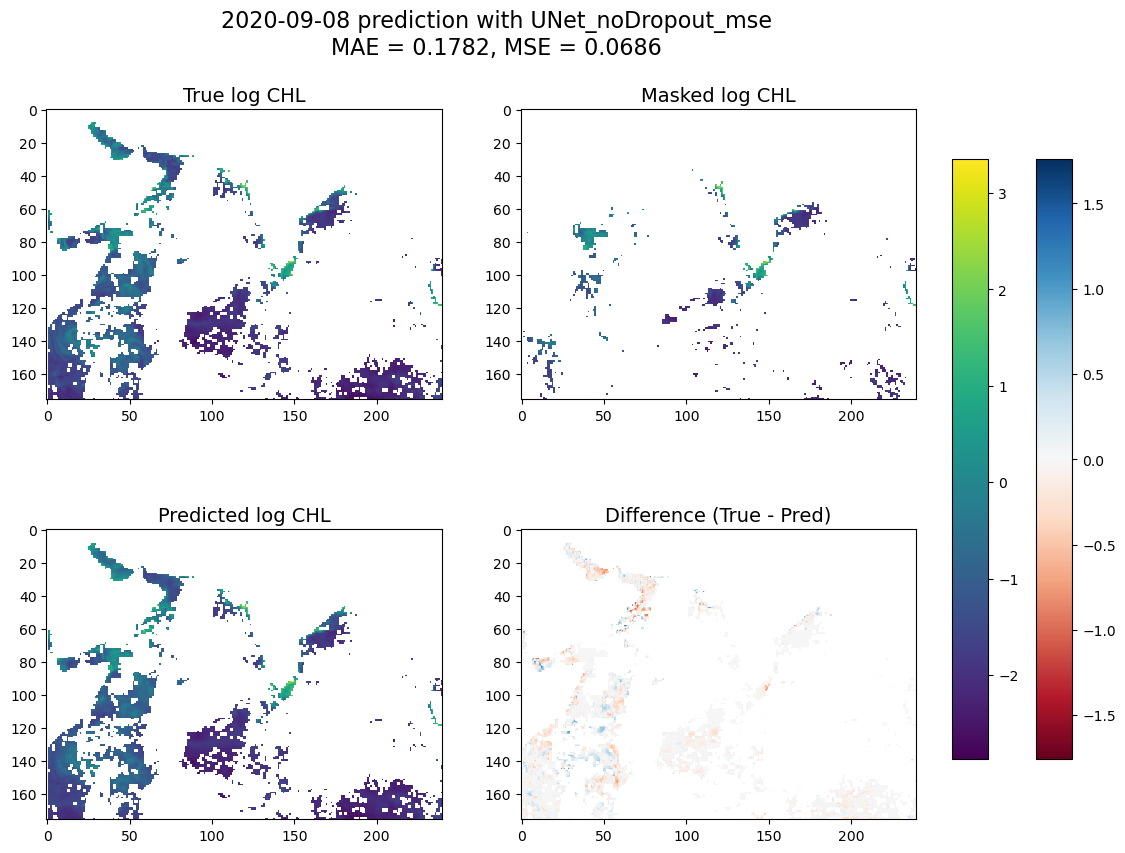

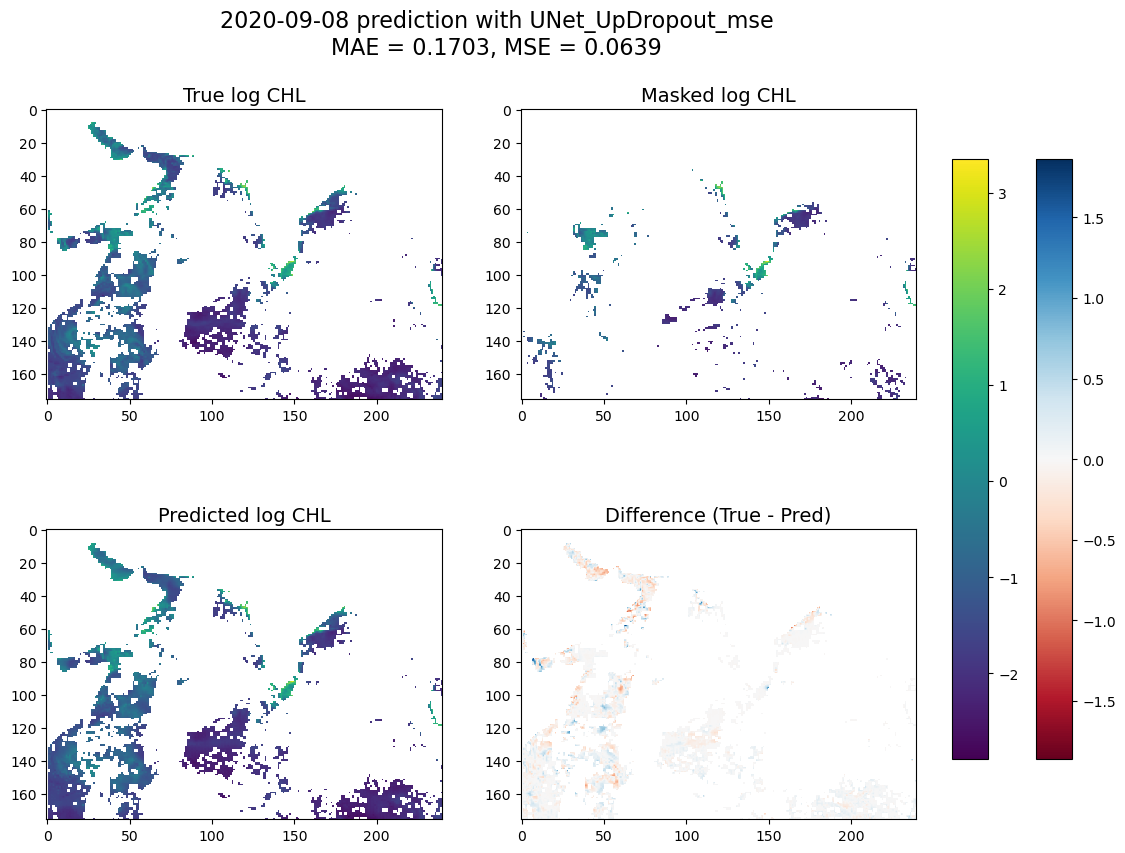

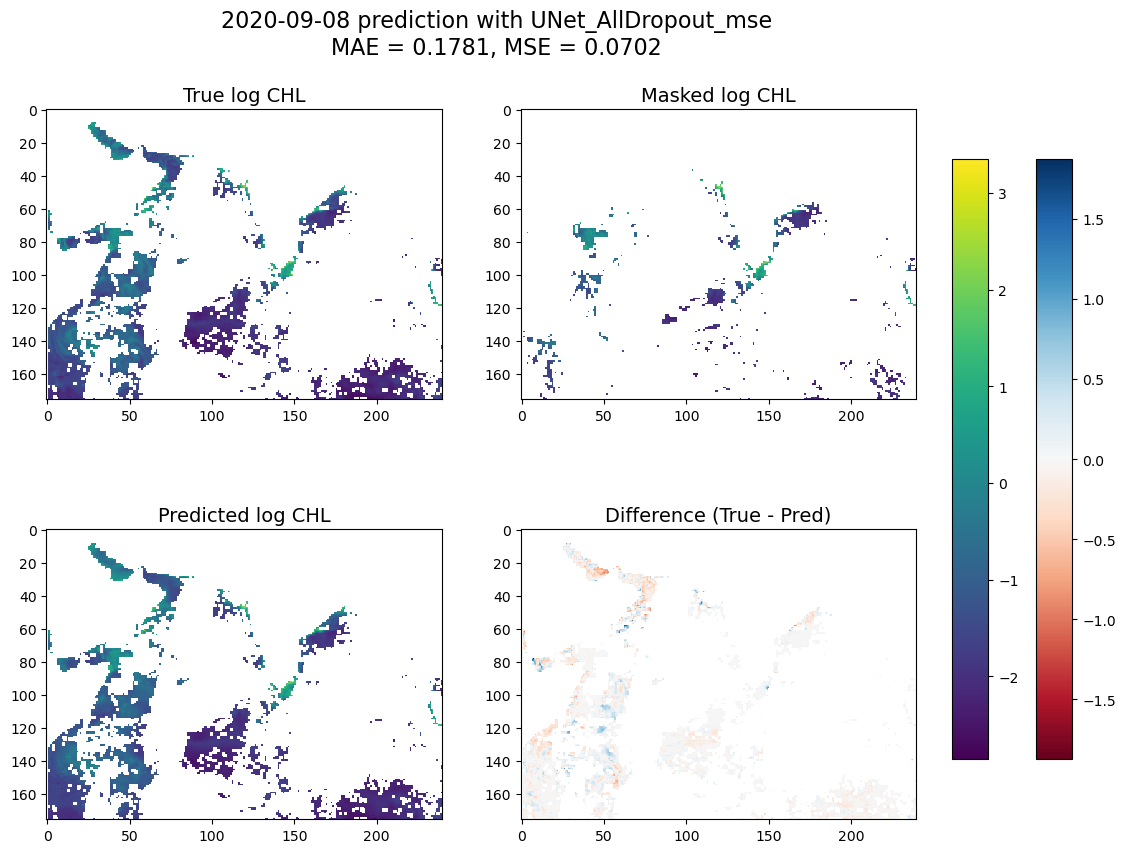

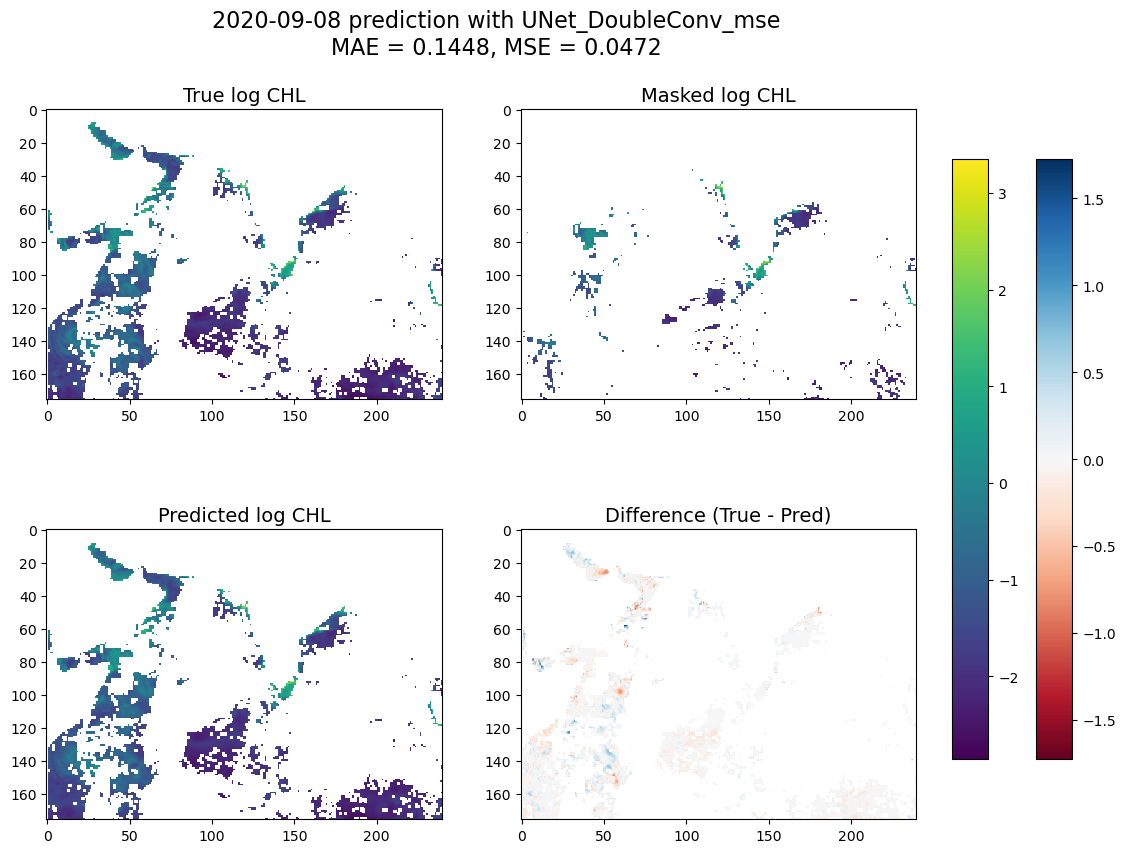

In [58]:
# models = [UNet_noDropout, UNet_UpDropout, UNet_AllDropout, UNet_Old]
model_names = ['UNet_noDropout_mse', 'UNet_UpDropout_mse', 'UNet_AllDropout_mse', 'UNet_DoubleConv_mse']
date = '2020-09-08'

for  model_name in model_names:
    model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
    plot_comparison(zarr_label, model, model_name, date)

In [ ]:
# model_names = ['UNet_noDropout', 'UNet_UpDropout', 'UNet_AllDropout', 'UNet_DoubleConv']
years = [2014, 2020, 2021, 2022]
# losses_list = []
losses_dict = {}

for year in years:
    loss_dict = {}
    print(year)
    for model_name in model_names:
        print(model_name)
        model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
        losses = plot_daily_losses(zarr_label, model, model_name, year, plot=False)
        loss_dict[model_name] = losses
    losses_dict[year] = loss_dict
    print('done')

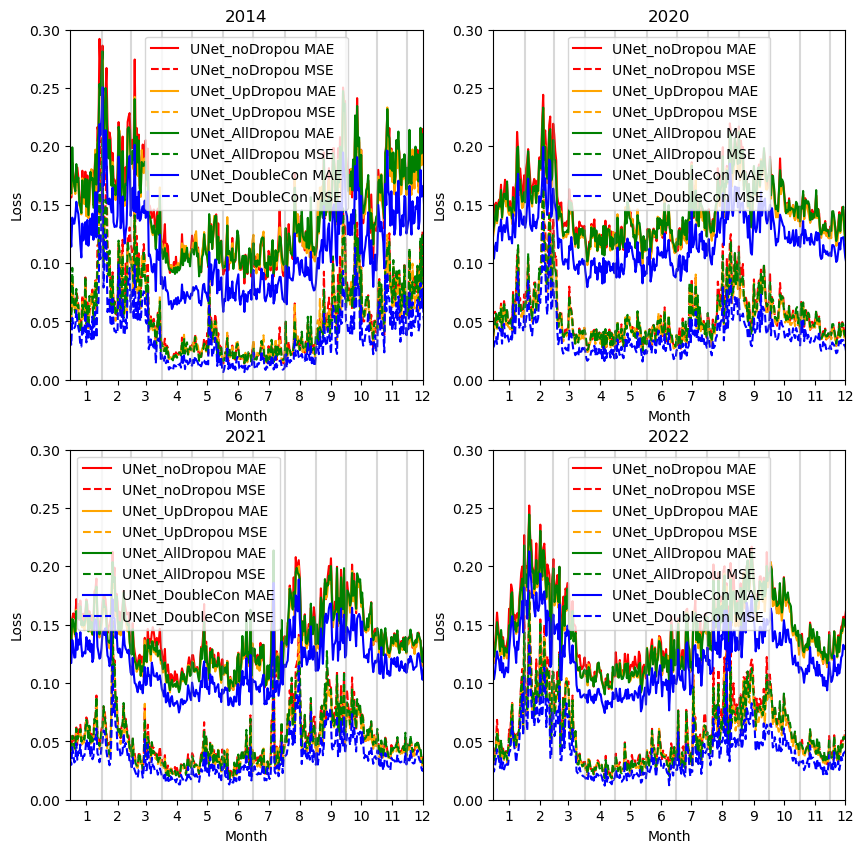

In [43]:
# # model_names = ['UNet_noDropout', 'UNet_UpDropout', 'UNet_AllDropout', 'UNet_DoubleConv']
# years = [2014, 2020, 2021, 2022]
# # losses_list = []
# losses_dict = {}

# for year in years:
#     loss_dict = {}
#     print(year)
#     for model_name in model_names:
#         print(model_name)
#         model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
#         losses = plot_daily_losses(zarr_label, model, model_name, year, plot=False)
#         loss_dict[model_name] = losses
#     losses_dict[year] = loss_dict
#     print('done')

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
colors = ['red', 'orange', 'green', 'blue']
for ax, year in zip(axes.flat, losses_dict):
    losses = losses_dict[year]
    for model, c in zip(losses, colors):
        loss = losses[model]
        ax.plot(loss[0], c=c, label=f'{model[:-5]} MAE')
        ax.plot(loss[1], c=c, ls='--', label=f'{model[:-5]} MSE')
    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        ax.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Loss')
    ax.set_xlim(0, len(losses))
    ax.set_ylim(0, 0.3)
    ax.set_xticks(tick_pos, tick_label)

    ax.legend()
    ax.set_title(year)

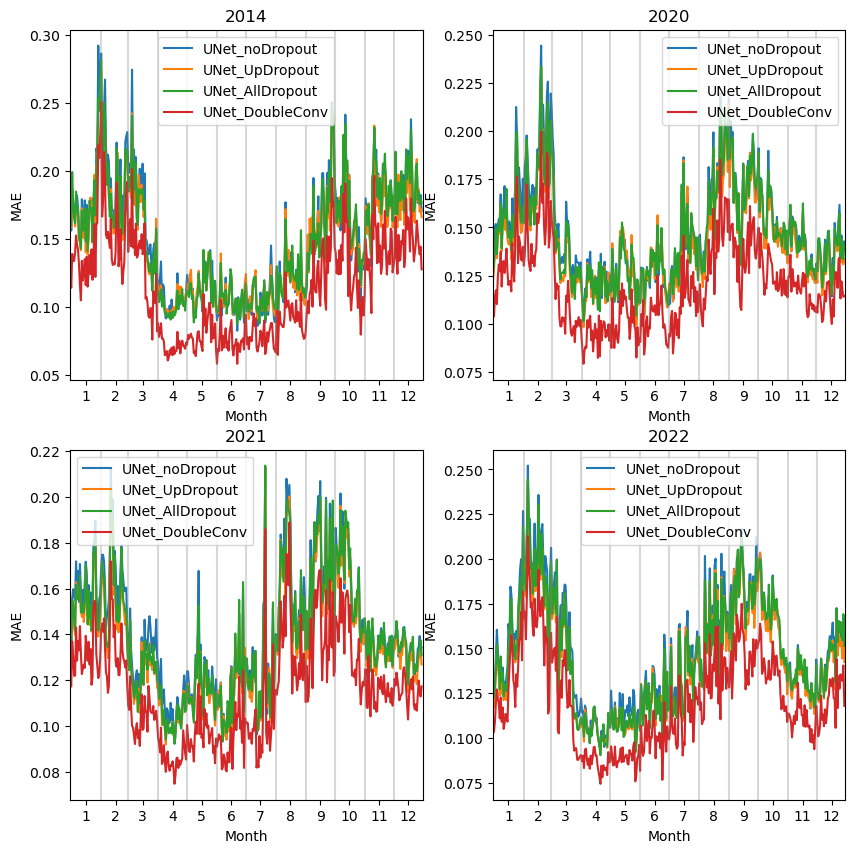

In [40]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
for ax, year in zip(axes.flat, losses_dict):
    losses = losses_dict[year]
    for model in losses:
        loss = losses[model]
        if year == 2022:
            loss = loss[:-1]
        ax.plot(loss, label=f'{model[:-4]}')
        
    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        ax.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    
    ax.set_xlabel('Month')
    ax.set_ylabel('MAE')
    ax.set_xlim(0, len(loss))
    # ax.set_ylim(0.05, 0.3)
    ax.set_xticks(tick_pos, tick_label)

    ax.legend()
    ax.set_title(year)
        
    

In [28]:
def plot_gapfill(zarr_label, model, model_name, date_to_predict):
    zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))
    mean_std = np.load(f'data/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind])
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
        # numer_features_stdized.append((feature - da.full(feature_shape, mean)) / da.full(feature_shape, stdev))
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = X_masked_CHL

    
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-gapfree'].to_numpy())
    # true_CHL = unstdize(true_CHL, mean, std)
    # fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    # masked_CHL = unstdize(masked_CHL, mean, std)
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    diff = true_CHL - predicted_CHL

    vmax = np.nanmax((true_CHL, masked_CHL, predicted_CHL, diff))
    vmin = np.nanmin((true_CHL, masked_CHL, predicted_CHL, diff))

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    im = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax)
    axes[0, 0].set_title('Gapfree log CHL', size=14)
    im = axes[0, 1].imshow(masked_CHL, vmin=vmin, vmax=vmax)
    # im = axes[0, 1].imshow(true_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    axes[0, 1].set_title('Level3 log CHL', size=14)
    # im = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    # predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)  #
    im = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax)
    axes[1, 0].set_title('Predicted log CHL', size=14)

    vmin2 = np.nanmin(diff)
    vmax2 = np.nanmax(diff)
    vmax2 = np.nanmax((np.abs(vmin2), np.abs(vmax2)))
    vmin2 = -vmax2
    # im2 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, cmap=plt.cm.RdBu, alpha=0.3)  #
    # diff = np.where(fake_cloud_flag == 0, np.nan, diff)  #
    im2 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, cmap=plt.cm.RdBu)
    axes[1, 1].set_title('Difference (True - Pred)', size=14)

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)

    cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    fig.colorbar(im2, cax=cbar2_ax)

    # predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    mae = compute_mae(true_CHL, predicted_CHL)
    mae = round(mae, 4)
    mse = compute_mse(true_CHL, predicted_CHL)
    mse = round(mse, 4)

    plt.suptitle(f'{date_to_predict} prediction with {model_name}\nMAE = {str(mae)}, MSE = {str(mse)}', size=16, y=0.95)
    plt.show()

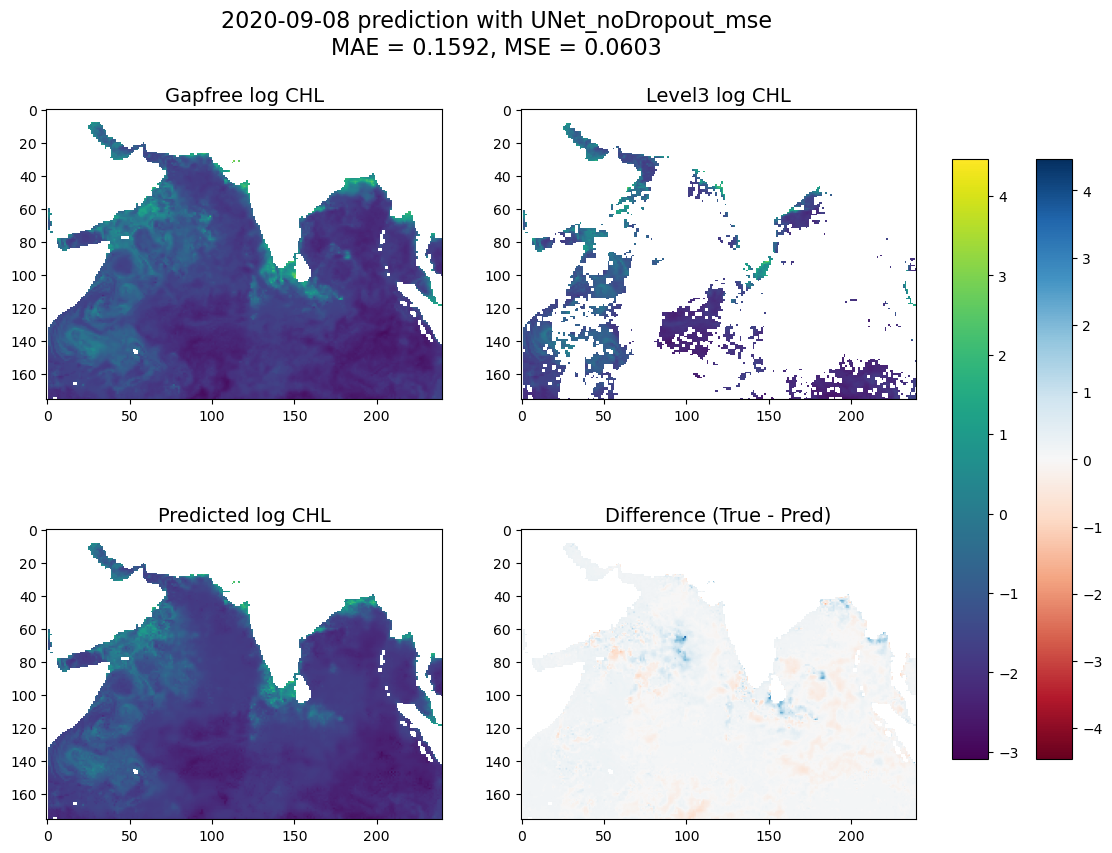

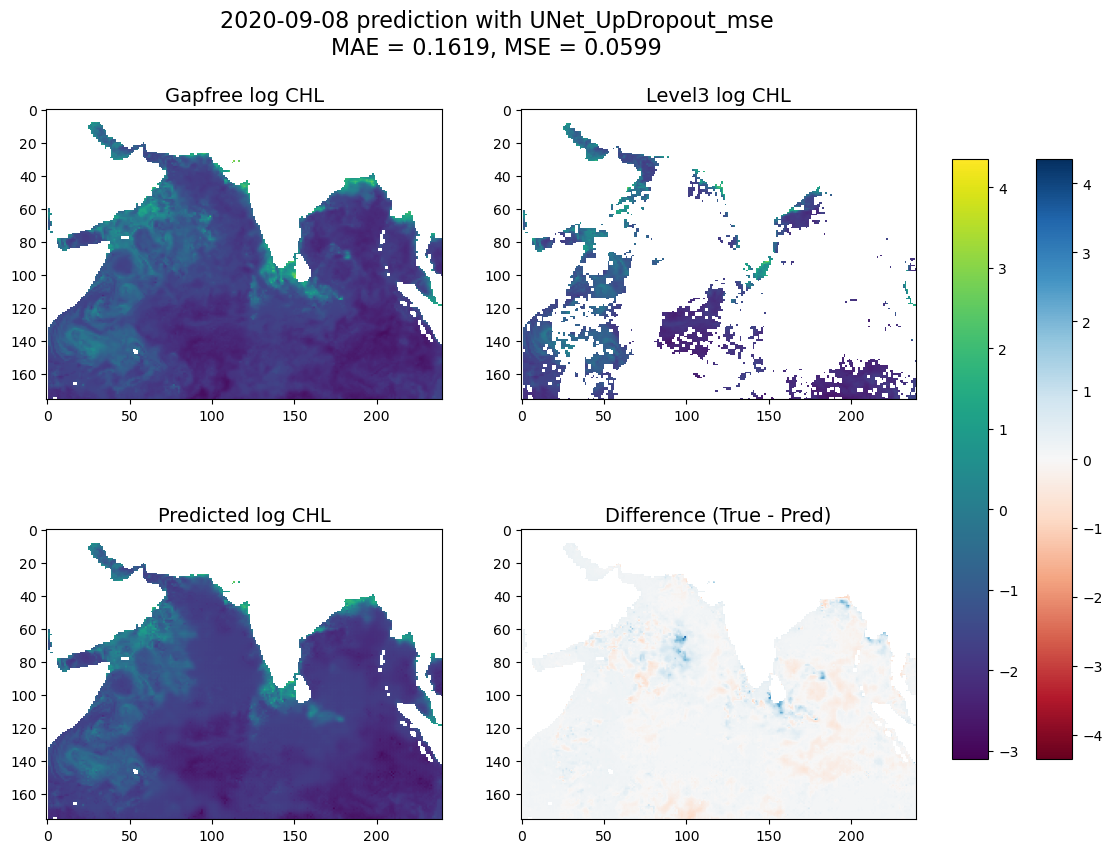

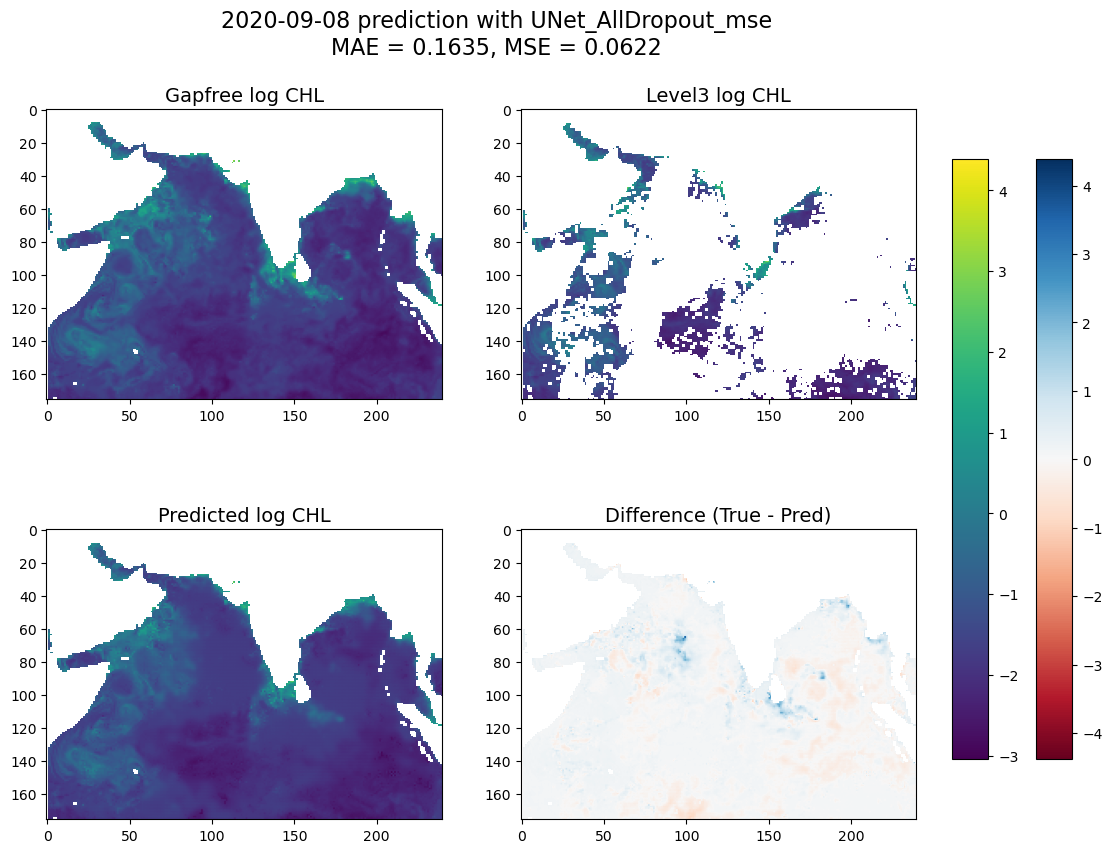

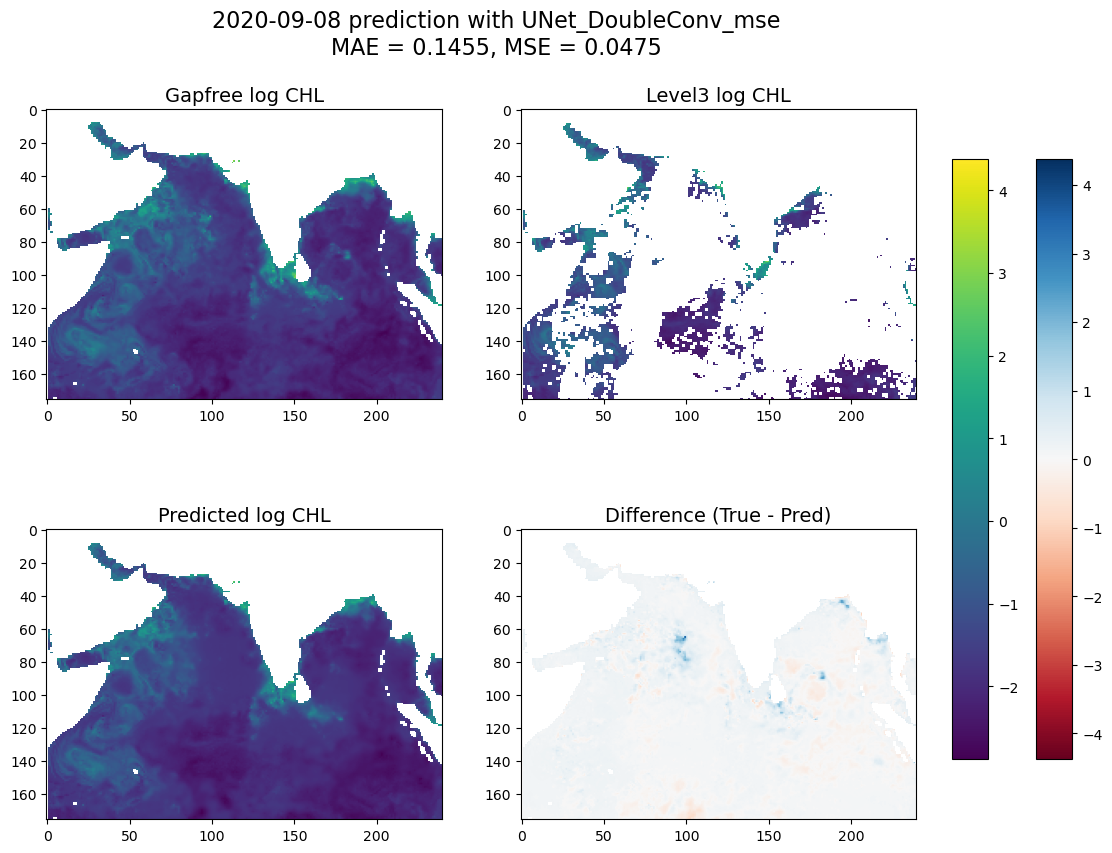

In [59]:
# models = [UNet_noDropout, UNet_UpDropout, UNet_AllDropout, UNet_Old]
model_names = ['UNet_noDropout_mse', 'UNet_UpDropout_mse', 'UNet_AllDropout_mse', 'UNet_DoubleConv_mse']
date = '2020-09-08'

for  model_name in model_names:
    model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
    plot_gapfill(zarr_label, model, model_name, date)

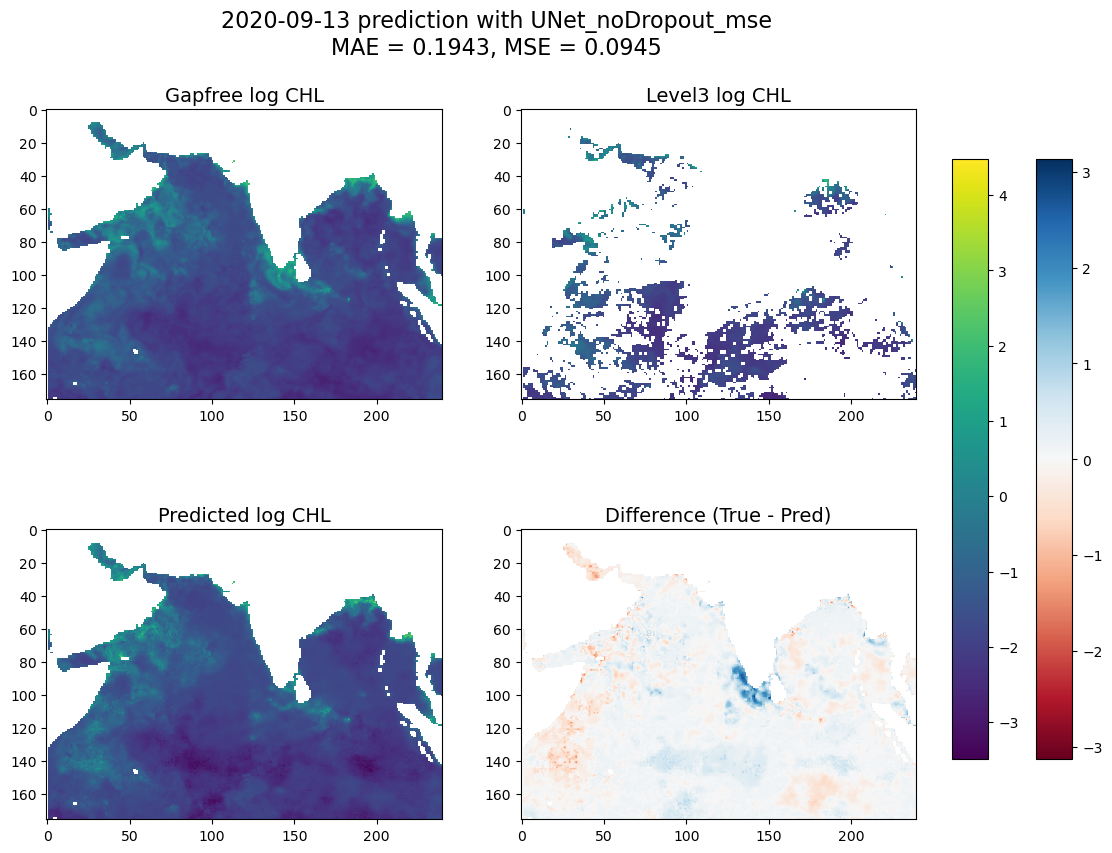

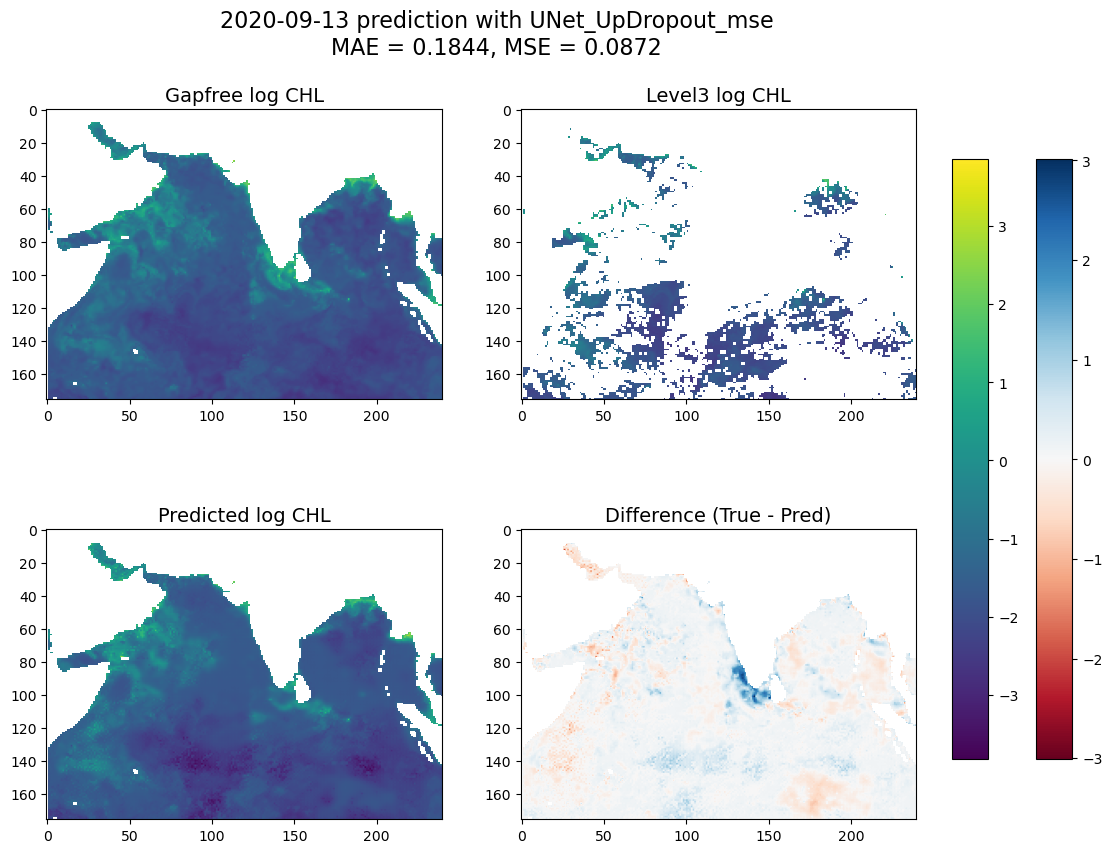

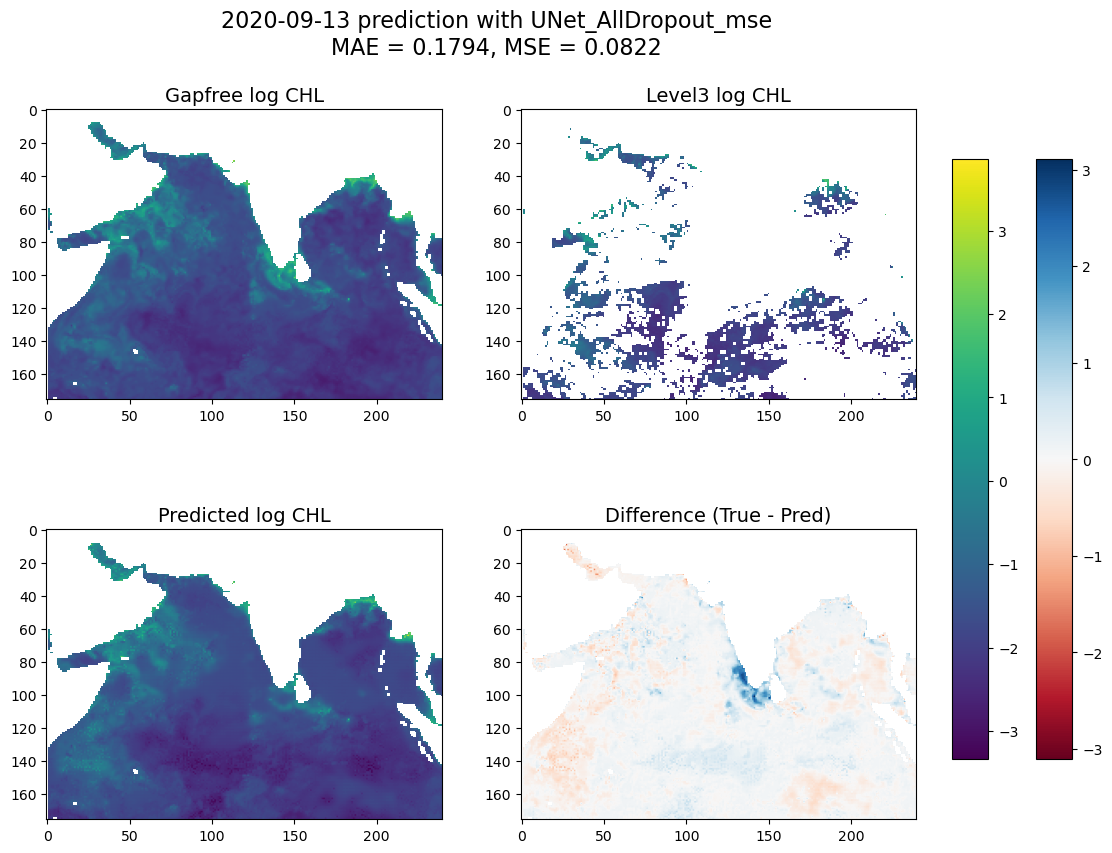

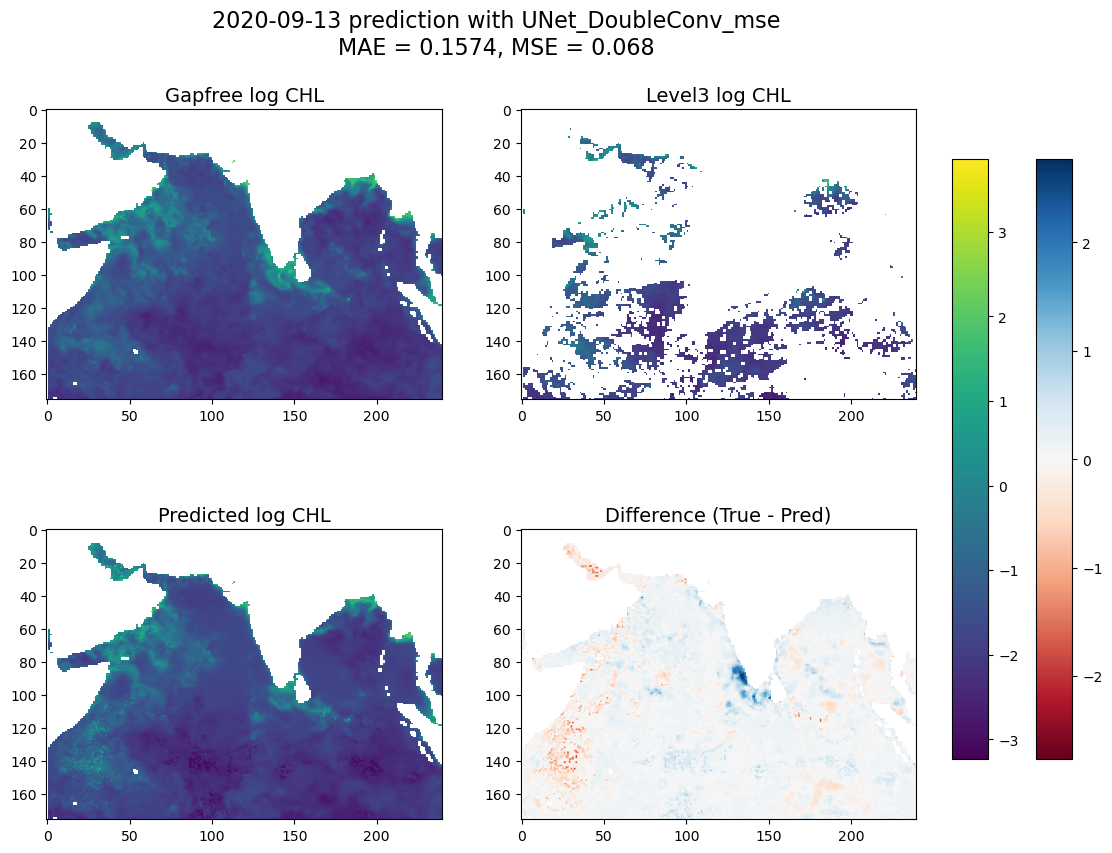

In [46]:
# models = [UNet_noDropout, UNet_UpDropout, UNet_AllDropout, UNet_Old]
model_names = ['UNet_noDropout_mse', 'UNet_UpDropout_mse', 'UNet_AllDropout_mse', 'UNet_DoubleConv_mse']
date = '2020-09-13'

for  model_name in model_names:
    model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
    plot_gapfill(zarr_label, model, model_name, date)

In [30]:
def gapfill_daily_losses(zarr_label, model, model_name, year, plot=True):
    zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))
    mean_std = np.load(f'data/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')
    title = f'{year} daily loss with {model_name}'

    zarr_time_range = zarr_stdized.sel(time=time_range)

    # for date in np.arange(f'{year}-01', f'{year + 1}-01', dtype='datetime64[D]'):
    #     if date not in time_range:
    #         losses.append(np.nan)
    #     else:
    # zarr_date = zarr_stdized.sel(time=date)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind]) 
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = X_masked_CHL
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-gapfree'].to_numpy())            
    # fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    # predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    mae = []
    mse = []
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
        mse.append(compute_mse(true, pred))

    if plot:
        plt.plot(mae, c='black')
    
        tick_pos = []
        tick_label = []
        total_day = 1
        tick_pos.append(total_day + 15)
        tick_label.append('1')
        for month in range(1, 12):
            total_day += calendar.monthrange(year, month)[1]
            plt.axvline(total_day, color='grey', alpha=0.3)
            tick_pos.append(total_day + 15)
            tick_label.append(str(month+1))
        plt.title(title)
        plt.xlabel('Month')
        plt.ylabel('Loss')
        plt.xlim(1, len(losses))
        plt.xticks(tick_pos, tick_label)
        plt.show()

    return mse

2014
UNet_noDropout_mse
UNet_UpDropout_mse
UNet_AllDropout_mse
UNet_DoubleConv_mse
done
2020
UNet_noDropout_mse
UNet_UpDropout_mse
UNet_AllDropout_mse
UNet_DoubleConv_mse
done
2021
UNet_noDropout_mse
UNet_UpDropout_mse
UNet_AllDropout_mse
UNet_DoubleConv_mse
done
2022
UNet_noDropout_mse
UNet_UpDropout_mse
UNet_AllDropout_mse
UNet_DoubleConv_mse
done


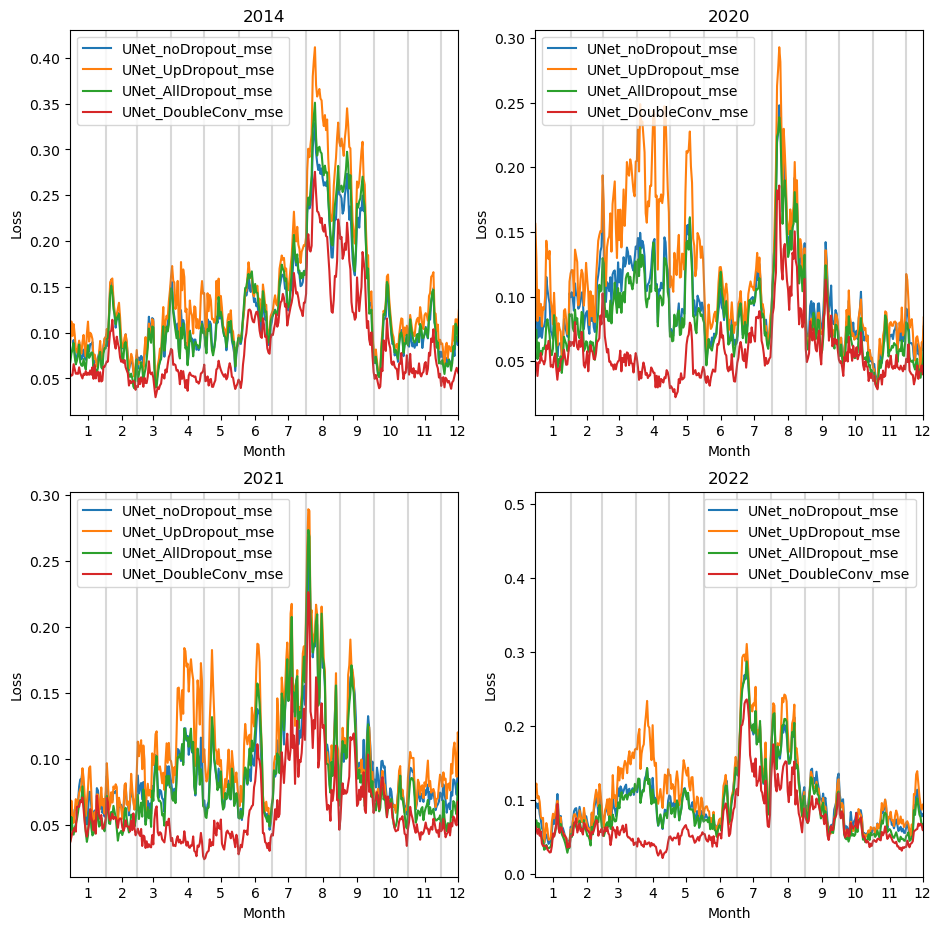

In [49]:
# model_names = ['UNet_noDropout', 'UNet_UpDropout', 'UNet_AllDropout', 'UNet_DoubleConv']
years = [2014, 2020, 2021, 2022]
# losses_list = []
losses_dict_fillgap = {}

for year in years:
    loss_dict_fill = {}
    print(year)
    for model_name in model_names:
        print(model_name)
        model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
        losses = gapfill_daily_losses(zarr_label, model, model_name, year, plot=False)
        loss_dict_fill[model_name] = losses
    losses_dict_fillgap[year] = loss_dict_fill
    print('done')

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11,11))
for ax, year in zip(axes.flat, losses_dict_fillgap):
    losses = losses_dict_fillgap[year]
    for model in losses:
        loss = losses[model]
        ax.plot(loss, label=model)
    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        ax.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Loss')
    ax.set_xlim(0, len(losses))
    # ax.set_ylim(0.05, 0.35)
    ax.set_xticks(tick_pos, tick_label)

    ax.legend()
    ax.set_title(year)

In [31]:
# model_names = ['UNet_noDropout', 'UNet_UpDropout', 'UNet_AllDropout', 'UNet_DoubleConv']
years = [2014, 2020, 2021, 2022]
# losses_list = []
losses_dict_fillgap = {}

for year in years:
    loss_dict_fill = {}
    print(year)
    for model_name in model_names:
        print(model_name)
        model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
        losses = gapfill_daily_losses(zarr_label, model, model_name, year, plot=False)
        loss_dict_fill[model_name] = losses
    losses_dict_fillgap[year] = loss_dict_fill
    print('done')

2014
UNet_noDropout_mse
UNet_UpDropout_mse
UNet_AllDropout_mse
UNet_DoubleConv_mse
done
2020
UNet_noDropout_mse
UNet_UpDropout_mse
UNet_AllDropout_mse
UNet_DoubleConv_mse
done
2021
UNet_noDropout_mse
UNet_UpDropout_mse
UNet_AllDropout_mse
UNet_DoubleConv_mse
done
2022
UNet_noDropout_mse
UNet_UpDropout_mse
UNet_AllDropout_mse
UNet_DoubleConv_mse
done


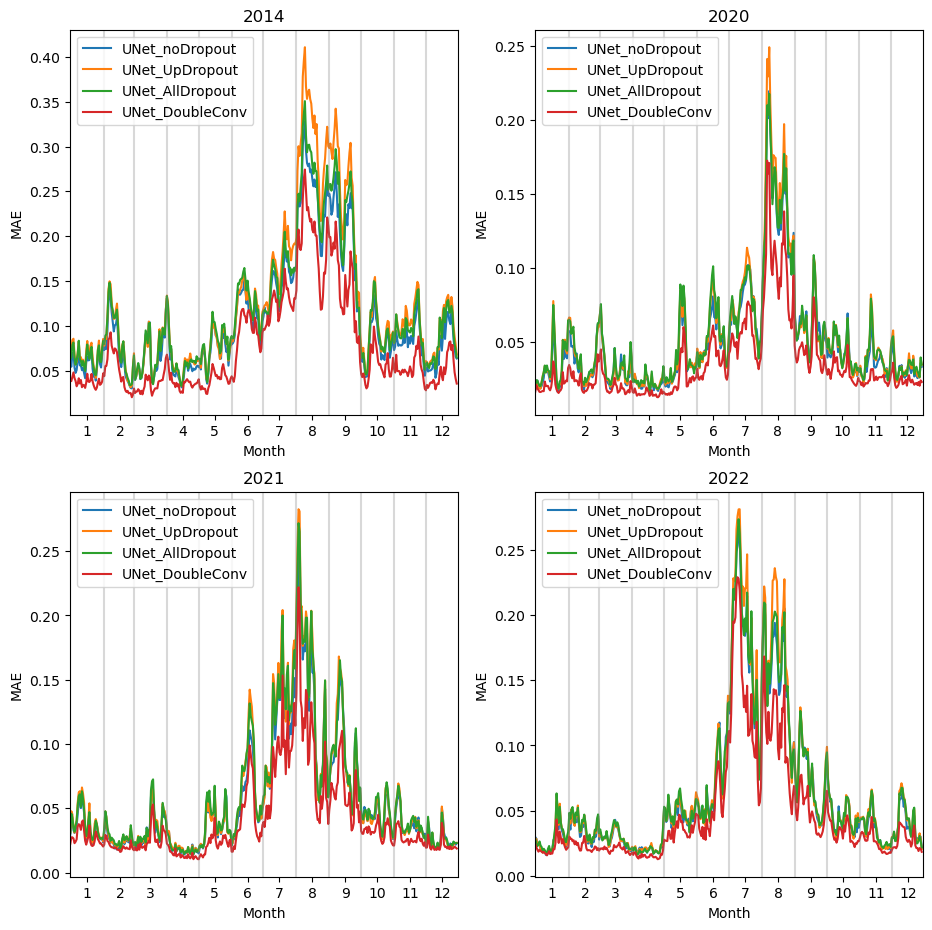

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11,11))
for ax, year in zip(axes.flat, losses_dict_fillgap):
    losses = losses_dict_fillgap[year]
    for model in losses:
        loss = losses[model]
        if year == 2022:
            loss = loss[:-1]
        ax.plot(loss, label=model[:-4])
    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        ax.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    
    ax.set_xlabel('Month')
    ax.set_ylabel('MAE')
    ax.set_xlim(0, len(loss))
    # ax.set_ylim(0.05, 0.35)
    ax.set_xticks(tick_pos, tick_label)

    ax.legend()
    ax.set_title(year)

In [ ]:
def plot_gapfill(zarr_label, model, model_name, date_to_predict):
    zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))
    mean_std = np.load(f'data/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X[X_vars.index('real_cloud_flag')] = np.zeros(X[0].shape)
    X[X_vars.index('valid_CHL_flag')] = np.zeros(X[0].shape)
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X[X_vars.index('fake_cloud_flag')] = da.where(daX_masked_CHL
    X_masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
        # numer_features_stdized.append((feature - da.full(feature_shape, mean)) / da.full(feature_shape, stdev))
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = X_masked_CHL
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-gapfree'].to_numpy())
    # true_CHL = unstdize(true_CHL, mean, std)
    # fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    # masked_CHL = unstdize(masked_CHL, mean, std)
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    diff = true_CHL - predicted_CHL

    vmax = np.nanmax((true_CHL, masked_CHL, predicted_CHL, diff))
    vmin = np.nanmin((true_CHL, masked_CHL, predicted_CHL, diff))

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    im = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax)
    axes[0, 0].set_title('Gapfree log CHL', size=14)
    im = axes[0, 1].imshow(masked_CHL, vmin=vmin, vmax=vmax)
    # im = axes[0, 1].imshow(true_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    axes[0, 1].set_title('Level3 log CHL', size=14)
    # im = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    # predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)  #
    im = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax)
    axes[1, 0].set_title('Predicted log CHL', size=14)

    vmin2 = np.nanmin(diff)
    vmax2 = np.nanmax(diff)
    vmax2 = np.nanmax((np.abs(vmin2), np.abs(vmax2)))
    vmin2 = -vmax2
    # im2 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, cmap=plt.cm.RdBu, alpha=0.3)  #
    # diff = np.where(fake_cloud_flag == 0, np.nan, diff)  #
    im2 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, cmap=plt.cm.RdBu)
    axes[1, 1].set_title('Difference (True - Pred)', size=14)

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)

    cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    fig.colorbar(im2, cax=cbar2_ax)

    # predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    mae = compute_mae(true_CHL, predicted_CHL)
    mae = round(mae, 4)
    mse = compute_mse(true_CHL, predicted_CHL)
    mse = round(mse, 4)

    plt.suptitle(f'{date_to_predict} prediction with {model_name}\nMAE = {str(mae)}, MSE = {str(mse)}', size=16, y=0.95)
    plt.show()

In [40]:
a = list(zarr_stdized.keys())
a.remove('CHL')
i = a.index('masked_CHL')
a[i] = 'CHL'
a

['air_temp',
 'cos_time',
 'fake_cloud_flag',
 'land_flag',
 'CHL',
 'next_day-CHL',
 'prev_day_CHL',
 'real_cloud_flag',
 'sin_time',
 'sst',
 'u_wind',
 'v_wind',
 'valid_CHL_flag']

In [27]:
for year in losses_dict:
    print(year)

2014
2020
2021
2022


In [ ]:
model_names = ['UNet_noDropout', 'UNet_UpDropout', 'UNet_AllDropout', 'UNet_DoubleConv']
year = 2021
losses_list = []

for model_name in model_names:
    model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')
    losses = plot_daily_losses(zarr_label, model, model_name, year)
    losses_list.append(losses)

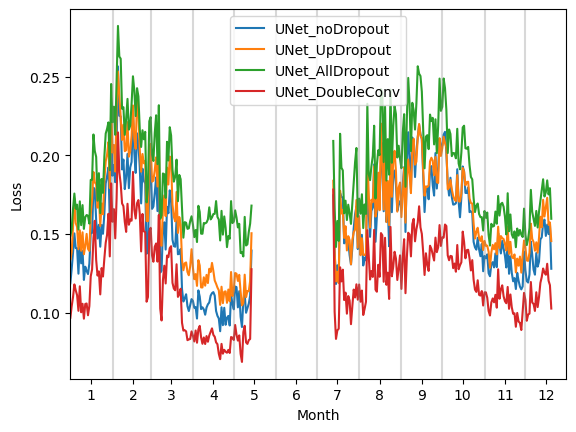

In [34]:
for loss, model in zip(losses_list, model_names):
    plt.plot(loss, label=model)
plt.legend()

tick_pos = []
tick_label = []
total_day = 1
tick_pos.append(total_day + 15)
tick_label.append('1')
for month in range(1, 12):
    total_day += calendar.monthrange(year, month)[1]
    plt.axvline(total_day, color='grey', alpha=0.3)
    tick_pos.append(total_day + 15)
    tick_label.append(str(month+1))

plt.xlabel('Month')
plt.ylabel('Loss')
plt.xlim(1, len(losses))
plt.xticks(tick_pos, tick_label)
plt.show()


In [32]:
round(1.27831, 2)

1.28

In [ ]:

    

def model_eval_yr(zarr_ds, model, X, mean, stdev, year, title, loss_fn=compute_mae):
    losses = []
    # mean_losses = []
    # partial_CHL_ind = []
   
    for month in range(1, 13):
        days = calendar.monthrange(int(year), month)[1]  # get number of days in month
        month_str = str(month) if month >= 10 else f'0{month}'
        for day in range(1, days+1):
            day_str = str(day) if day >= 10 else f'0{day}'
            date = np.datetime64(f'{year}-{month_str}-{day_str}')  # convert date str to datetime64
            date_index = np.where(zarr_CHL.time.values == date)[0]  # get index of given date
            if len(date_index) != 0:  # if date with CHL data
                date_index = date_index[0]
                true_output = zarr_CHL.sel(time=date).CHL
                true_output = np.log(true_output)  # true log(CHL)
                partial_CHL_ind.append(da.isnan(da.where(~CHL_mask, 0.0, true_output)).any().compute())
                input = X[date_index]
                input = np.array(input)
                predicted_output = model.predict(input[np.newaxis, ...], verbose=0)[0]
                predicted_output = predicted_output[:,:,0]
                predicted_output = unstdize(predicted_output, mean, stdev)
                losses.append(loss_fn(np.array(true_output), predicted_output))
            else:
                losses.append(-1)
                partial_CHL_ind.append(False)

    plot_test_losses(losses, year, partial_CHL_ind, title)
    
            
    return losses

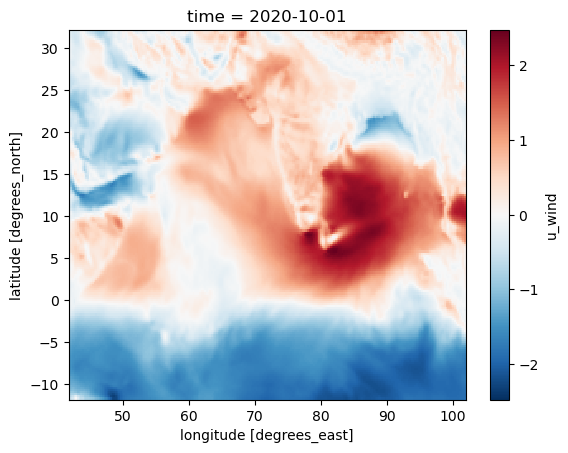

In [20]:
zarr_processed.sel(time='2020-10-01').u_wind.plot()

In [16]:
np.save('test.npy', np.array([1,2,3]))

In [17]:
np.load('test.npy')

array([1, 2, 3])

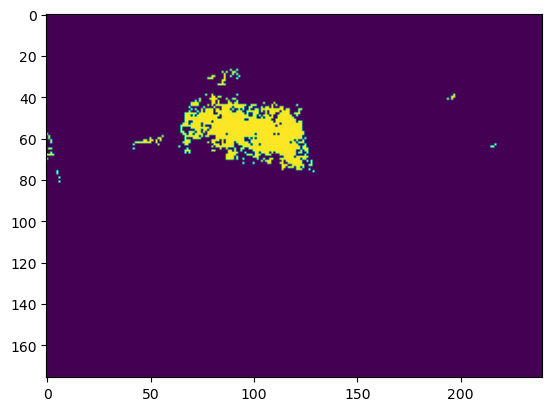

In [20]:
CHL_data = zarr_ds.sel(time='2022-08-10').CHL
a = da.zeros(CHL_data.shape)
a = da.where(da.isnan(CHL_data) & CHL_mask, 1, a)
plt.imshow(a)

In [3]:
import xarray as xr
import pandas as pd
import zarr
ds0 = xr.Dataset({'temperature': (['time'],  [50, 51, 52])}, coords={'time': pd.date_range('2000-01-01', periods=3)})
ds1 = xr.Dataset({'pressure': (['time'],  [50, 51, 52])}, coords={'time': pd.date_range('2000-01-01', periods=3)})
store = zarr.DirectoryStore('test.zarr')
ds0.to_zarr(store, mode='w')
ds1.to_zarr(store, mode='a')
xr.open_zarr(store)

<xarray.Dataset> Size: 72B
Dimensions:      (time: 3)
Coordinates:
  * time         (time) datetime64[ns] 24B 2000-01-01 2000-01-02 2000-01-03
Data variables:
    pressure     (time) int64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    temperature  (time) int64 24B dask.array<chunksize=(3,), meta=np.ndarray>

In [8]:
store['temperature']

KeyError: 'temperature'

In [ ]:
'''
训练结构：
A. 数据处理
    1. lat lon slice  √
    2. take out all nan CHL  √
    3. sort by time  √
    4. create mask for flagging (figure out how)  √

    1. select features and labels, convert to da array, add in additional features
    2. select variables that need standardization, calculate based on train data
    3. standardize all data
    3.1. save all standardized data
    4. resizing
    5. data split


from 3.1: 最开始加一行：如果这个zarr file存在 -> 直接读取；不存在再进行下面的操作
'''

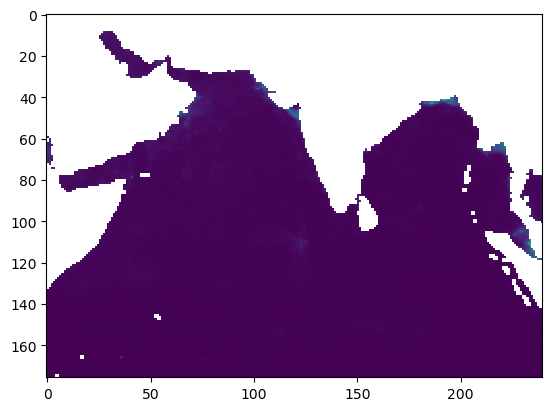

False

In [33]:
a = zarr_ds.sel(time='2022-01-01').CHL
plt.imshow(a)
plt.show()
a = da.where(~da.isnan(a), 10.0, a)
a_notnan = da.where(~CHL_mask, 10.0, a)
plt.imshow(a_notnan)
plt.show()
plt.imshow(CHL_mask)
np.isnan(a_notnan).any().compute()
# plt.imshow(zarr_ds.sel(time='2018-10-01').sst)